In [7]:
#importing the neccessary libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from scipy.stats import boxcox
from scipy import stats

In [9]:
try:
    data = pd.read_csv('SQL_Dataset.csv')
    num_rows = len(data)
    print(f"The number of rows in the dataset is: {num_rows}")
except FileNotFoundError:
    print("Error: The file 'Modified_SQL_Dataset.csv' was not found.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except Exception as e:
    print(f"An error occurred: {e}")


The number of rows in the dataset is: 30919


In [11]:
# Access the 36th row (index 35)
data.iloc[35]

Query    or 1  =  1/*
Label               1
Name: 35, dtype: object

In [13]:
#number of columns
print("Number of columns in dataset : {}".format(data.shape[1]))

Number of columns in dataset : 2


In [15]:
#printing the columns
print("The dataset columns are : ")

for i in data.columns:
    print(i)

The dataset columns are : 
Query
Label


In [17]:
#displaying first few rows of dataset
data.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


#### Information of the dataset

In [20]:
#brief information about data columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   30919 non-null  object
 1   Label   30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


###### We have only two data fields here, consisting of :
###### Query : It contains SQLI query, sql query or plain text and it is of object type
###### Label : The label that we are trying to predict i.e 1 means it is SQLI query and 0 means Normal SQL query or plain text¶

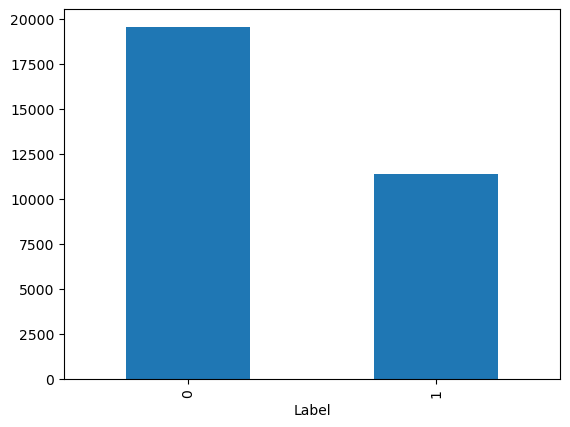

Total data points that belong to label 1: 11382, Percent: 36.81%
Total data points that belong to label 0: 19537, Percent: 63.19%


In [23]:
import matplotlib.pyplot as plt

# Group by 'Label' and count how many queries belong to each label
data.groupby('Label')['Query'].count().plot(kind='bar')
plt.show()

# Calculate and print how many data points belong to label 1 and label 0
label_1_count = data['Label'].value_counts()[1]
label_0_count = data['Label'].value_counts()[0]

print(f"Total data points that belong to label 1: {label_1_count}, Percent: {round((label_1_count / data.shape[0]) * 100, 2)}%")
print(f"Total data points that belong to label 0: {label_0_count}, Percent: {round((label_0_count / data.shape[0]) * 100, 2)}%")

###### Observations:
###### Majority of data points belongs to label 0 i.e normal sql queries or plain text are more in data points
###### there is a class imbalance between data points.

#### Checking for duplicates

In [29]:
#checking if there any duplicate rows present in dataset
data.duplicated(subset = ['Query','Label']).sum()

12

In [33]:
'''
As we can see from above result there are 12 rows which are duplicates
so lets see which all are the rows which are duplicates

'''

boolean_mask = data.duplicated(subset = ['Query','Label'])
data[boolean_mask]

,Query,Label
866,#NAME?,1
13532,#NAME?,0
14626,1.94E+15,0
15635,#NAME?,0
17255,1.86E+15,0
17913,#NAME?,0
18233,#NAME?,0
18875,#NAME?,0
18961,7.75E+15,0
19328,26%,1


###### Observations:
###### There are 12 rows which are duplicates it means they are repeated so we can remove the duplicate rows¶

In [36]:
data.shape

(30919, 2)

In [38]:
#remove the duplicate rows
data.drop_duplicates(subset = ['Query','Label'],inplace = True)

In [40]:
data.shape

(30907, 2)

In [42]:
#rechecking if there are any duplicate present now or not to ensure above code worked or not
data.duplicated().sum()

0

#### Checking for NULL values

In [45]:
#checking if there are any null value present in dataset
data.isnull().sum()

Query    0
Label    0
dtype: int64

#### Check if any same query has different labels

In [48]:
data.duplicated(subset = ['Query'],keep = False).sum()

4

###### we have 4 rows that have same query but different labels

In [51]:
# drop the duplicates
data.drop_duplicates(subset = ['Query'],keep= False,inplace = True)

In [53]:
data.shape

(30903, 2)

#### Checking distribution of data points among output classes after removing duplicate rows

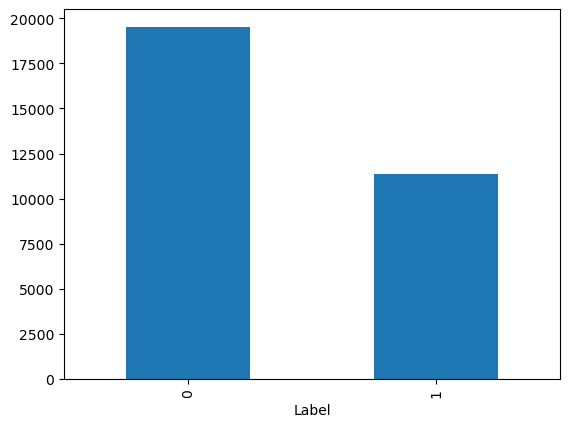

Total data points that belong to label 1: 11376, Percent: 36.81%
Total data points that belong to label 0: 19527, Percent: 63.19%


In [56]:
# Group by 'Label' and count how many queries belong to each label
data.groupby('Label')['Query'].count().plot(kind='bar')
plt.show()

# Calculate and print how many data points belong to label 1 and label 0
label_1_count = data['Label'].value_counts()[1]
label_0_count = data['Label'].value_counts()[0]

print(f"Total data points that belong to label 1: {label_1_count}, Percent: {round((label_1_count / data.shape[0]) * 100, 2)}%")
print(f"Total data points that belong to label 0: {label_0_count}, Percent: {round((label_0_count / data.shape[0]) * 100, 2)}%")

###### Observations:
###### There is only a slight difference in distribution¶

#### Plotting wordclouds

In [62]:
#first we will separate out the queries of different labels
label_1_text = ""
label_0_text = ""
for i in range(data.shape[0]):
    #fetching the query based on index and convert it to string
    q = str(data['Query'].iloc[i])
    
    #split the queries
    t = q.split()
    
    if(data['Label'].iloc[i] == 1):
        label_1_text+= " ".join(t) + " "
    else:
        label_0_text+= " ".join(t) + " "

#### Plotting the wordclouds for the label1 i.e SQL Injection queries text

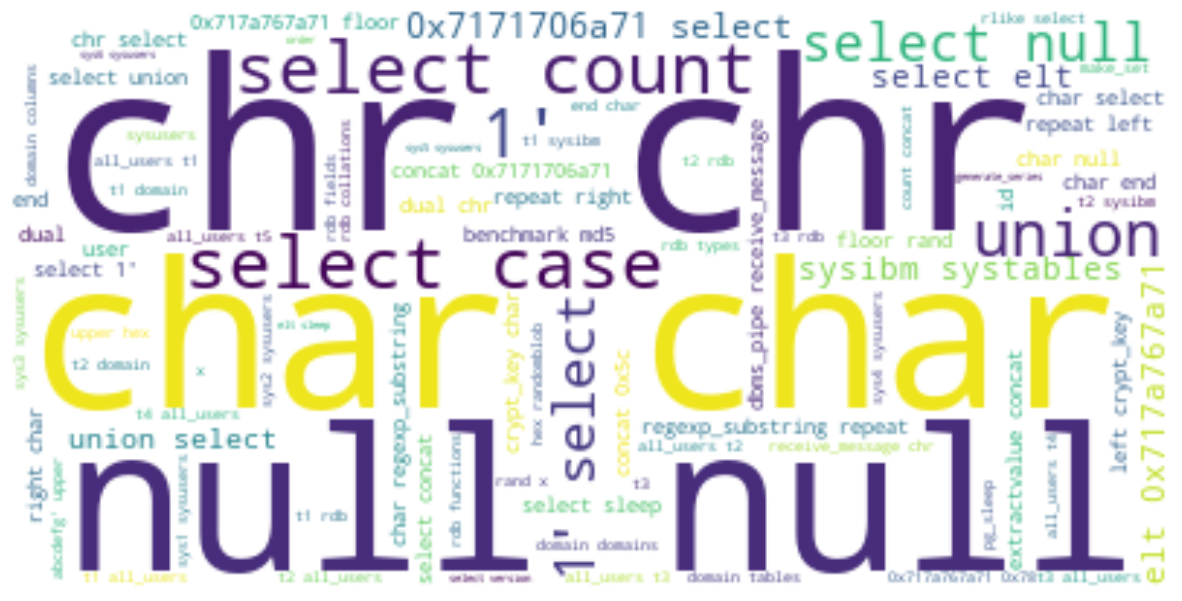

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#plot the worldcloud of label 1 queries
wordcloud = WordCloud(background_color = "white").generate(label_1_text)
plt.figure(figsize = (15,12))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

###### Observations:
###### In Label 1 i.e null, chr, char union, select count case are the words that occur more in sql injection queries.
###### these most occuring words are helpful for feature engineering purpose.¶

#### Plotting the wordclouds for the label0 i.e SQL Injection queries text¶

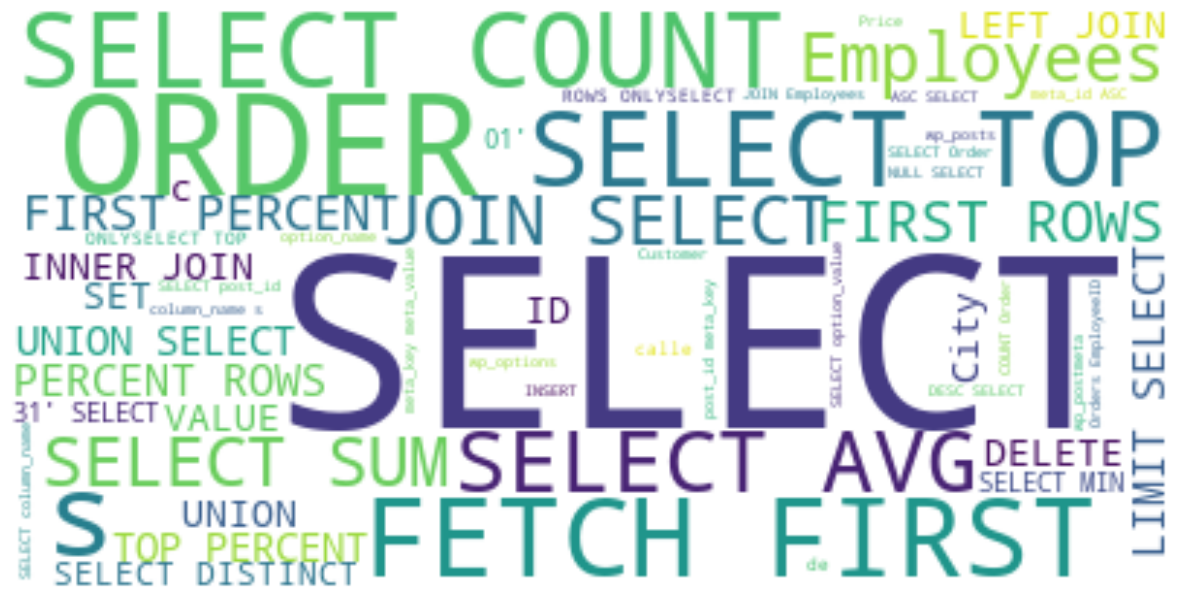

In [69]:
#plot the worldcloud of label 0 queries
wordcloud = WordCloud(background_color = "white").generate(label_0_text)
plt.figure(figsize = (15,12))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

###### Observation :
###### As we can see select, top, order, count, avg, join etc these are the normal sql keywords that occur more in sql queries

#### Preprocessing of Text

###### ->From the above given dataset queries we can see that the queries are composition of special characters, punctuations etc. these are all the features that differntiate between the normal sql query and SQL Injected query.
###### ->So we will not perform remove of punctuations, html tags etc as a part of text preprocessing.
###### ->stemming of words and stop word removal is also not performed because it removes some special characters which are very critical for feature engineering and differntiating between sql and sqli queries.
###### ->So as preprocessing of text will only convert text to lowercase.

#### Converting Text column values to lowercase

In [75]:
def Preprocess(text):
    
    #converting text to lowercase
    text = str(text).lower()

    return text

#applying above function to queries
data['Query'] = data['Query'].apply(Preprocess)

In [77]:
#checking whether the above code worked or not
data['Query'][0]

'" or pg_sleep  (  __time__  )  --'

#### Feature Extraction

###### The Features are :
###### ~ query_len = length of each query
###### ~num_word_query = total numbers of words in a query.
###### ~no_single_qts = Number of single quotation in a query
###### ~no_double_qts = number of double quotation in a query.
###### ~no_punctn = total number of punctuation in a query.
###### ~no_single_cmnt = number of single line comments in a query.
###### ~no_double_cmnt = number of double line comments in a query.
###### ~no_white_space = number of white space in a query.
###### ~no_percent = number of percentage symbols.
###### ~no_log_optr = total number of logical operator in a query.
###### ~no_arith_oprtr = total number of arithmetic operator.
###### ~no_null_val = total number of null values in a query.
###### ~no_hexdec_val = total number of hexa decimal values.
###### ~no_alphabet = total number of alphabets in a query.
###### ~no_digits = total number of digits.
###### ~len_of_chr_char_null = length of chr + char + null keywords this feature is based on wordcloud above.
###### ~genuine_keywords = this keywords are also generated using wordclouds for label 0 classes text this keywords includes select,top,order,fetch,join,avg,count,sum,rows.


#### Creating the above mentioned features and adding it to the dataframe

In [82]:
'''
we will create all the features mentioned above and store it in a dataframe

'''
#length of a query
data['query_len'] = data['Query'].apply(lambda x : len(x))


#number of words in a query
data['num_words_query'] = data['Query'].apply(lambda x : len(x.split()))


#number of single quotation in a query
def single_qt(x):
    r = re.compile(r"'")
    l = r.findall(x)
    return len(l)
data['no_single_qts'] = data['Query'].apply(single_qt)


#number of double quotation in a query
def double_qt(x):
    r = re.compile(r'"')
    l = r.findall(x)
    return len(l)
data['no_double_qts'] = data['Query'].apply(double_qt)

#number of punctuations 
def punctuation(x):
    r = re.compile("[!\"#$%&\'()*+,-.\/:;<=>?@[\\]^_`{|}~]")
    l = r.findall(x)
    return len(l)
data['no_punct'] = data['Query'].apply(punctuation)


#number of single line comment
def sin_comm(x):
    r = re.compile(r'(--)')
    l = r.findall(x)
    return len(l)
data['no_single_cmnt'] = data['Query'].apply(sin_comm)

#number of multiline comments
def mult_comm(x):
    r = re.compile(r'(\/\*)')
    l = r.findall(x)
    return len(l)
data['no_mult_cmnt'] = data['Query'].apply(mult_comm)


#number of white spaces in a query
def space(x):
    r = re.compile(r'\s+')
    l = r.findall(x)
    return len(l)
data['no_space'] = data['Query'].apply(space) 


#number of percentage(%) symbols in a query.
def perc(x):
    r = re.compile(r'%')
    l = r.findall(x)
    return len(l)
data['no_perc'] = data['Query'].apply(perc)


#total number of logical operator in a query
#logical operators are and,or,not,xor,&&,||,!
#https://stackoverflow.com/questions/43079182/how-to-find-logic-operators-in-string-with-regex
def logical(x):
    r = re.compile(r'\snot\s|\sand\s|\sor\s|\sxor\s|&&|\|\||!')
    l = r.findall(x)
    return len(l)
data['no_log_opt'] = data['Query'].apply(logical)


#total number of arithmetic operators
def arithmetic(x):
    r = re.compile(r'\+|-|[^\/]\*|\/[^\*]')
    l = r.findall(x)
    return len(l)
data['no_arith'] = data['Query'].apply(arithmetic)


#number of null values in a query
def null_val(x):
    r = re.compile(r'null')
    l = r.findall(x)
    return len(l)
data['no_null'] = data['Query'].apply(null_val)


#number of hexadecimal values
def hexa(x):
    r = re.compile(r'0[xX][0-9a-fA-F]+\s')
    l = r.findall(x)
    return len(l)
data['no_hexa'] = data['Query'].apply(hexa)


#number of alphabets
def alphabet(x):
    r = re.compile(r'[a-zA-Z]')
    l = r.findall(x)
    return len(l)
data['no_alpha'] = data['Query'].apply(alphabet)


#number of digits
def digit(x):
    r = re.compile(r'[0-9]')
    l = r.findall(x)
    return len(l)
data['no_digit']  =data['Query'].apply(digit)


#length of chr+char+null keywords
def combined_keywords(x):
    r = re.compile(r'null')
    m = re.compile(r'chr')
    n = re.compile(r'char')
    l = r.findall(x)
    k = m.findall(x)
    j = n.findall(x)
    return len(l) + len(k) + len(j)
data['len_of_chr_char_null'] = data['Query'].apply(combined_keywords)


#genuine_keywords
#genuine keywords are based on wordclouds : select,top,order,fetch,join,avg,count,sum,rows.
#will check how many number of these keywords are present in each query.

def genuine(x):
    count = 0
    genuine_keys = ['select','top','order','fetch','join','avg','count','sum','rows']
    for i in x.split():
        if(i in genuine_keys):
            count = count + 1
    return count

data['genuine_keywords'] = data['Query'].apply(genuine)
        

In [84]:
data['Query'][3]

" select * from users where id  =  '1' or @ @1  =  1 union select 1,version  (    )   -- 1'"

In [86]:
data.head()

,Query,Label,query_len,num_words_query,no_single_qts,no_double_qts,no_punct,no_single_cmnt,no_mult_cmnt,no_space,no_perc,no_log_opt,no_arith,no_null,no_hexa,no_alpha,no_digit,len_of_chr_char_null,genuine_keywords
0,""" or pg_sleep ( __time__ ) --",1,33,7,0,1,10,1,0,6,0,1,2,0,0,13,0,0,0
1,create user name identified by pass123 tempora...,1,90,12,0,0,1,0,0,11,0,0,0,0,0,75,3,0,0
2,and 1 = utl_inaddr.get_host_address ( ...,1,218,35,3,0,25,0,0,35,0,2,0,0,0,120,2,0,2
3,select * from users where id = '1' or @ @1 ...,1,90,20,3,0,13,1,0,20,0,1,3,0,0,42,5,0,2
4,"select * from users where id = 1 or 1#"" ( ...",1,85,18,0,1,10,1,0,18,0,1,3,0,0,42,4,0,2


In [88]:
#saving the extracted features dataframe to csv file
data.to_csv('feature_extracted.csv',index = False)

#### Analysis of extracted features

##### query_len : Length of each query

In [92]:
#query_len
data['query_len'].describe()

count    30903.000000
mean        68.915866
std         81.152993
min          1.000000
25%         21.000000
50%         48.000000
75%         81.000000
max       5370.000000
Name: query_len, dtype: float64

##### Observations :
##### Minimum length of a query is 1.
##### maximum length of a query is 5370. and mean length is 68.

#### Feature vs output classes plot

##### Violin plot : Query_length vs Labels

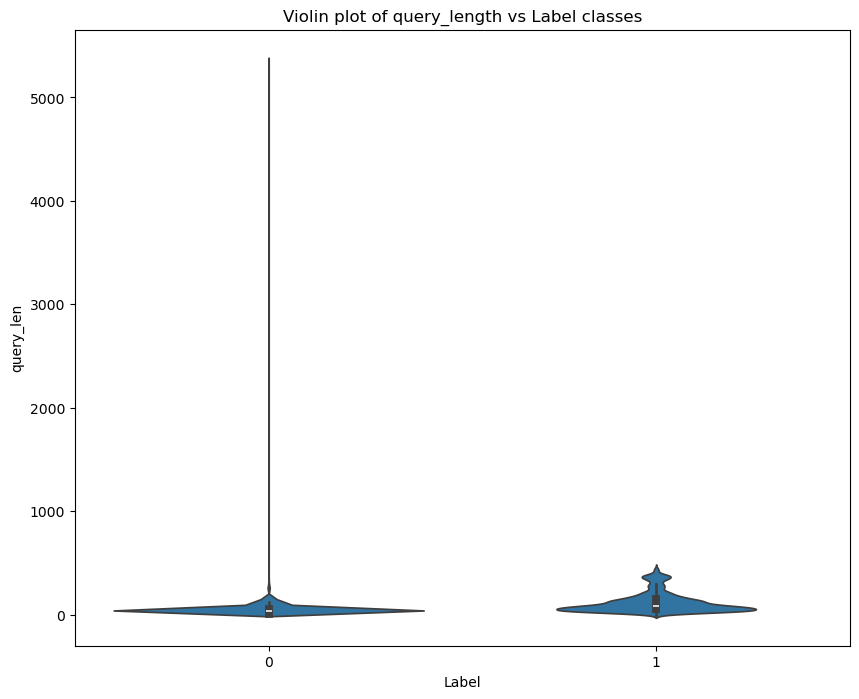

In [97]:
import seaborn as sns
#feature vs ouput plots
#will check whether the feature helpful in predicting the output labels
#will plot voilin plot and distribution plots
#univariate analysis

#violin plots
plt.figure(figsize = (10,8))


sns.violinplot(x = data['Label'],y = data['query_len'],data=data)
plt.title("Violin plot of query_length vs Label classes")

plt.show()

####  Distribution of query_length vs labels

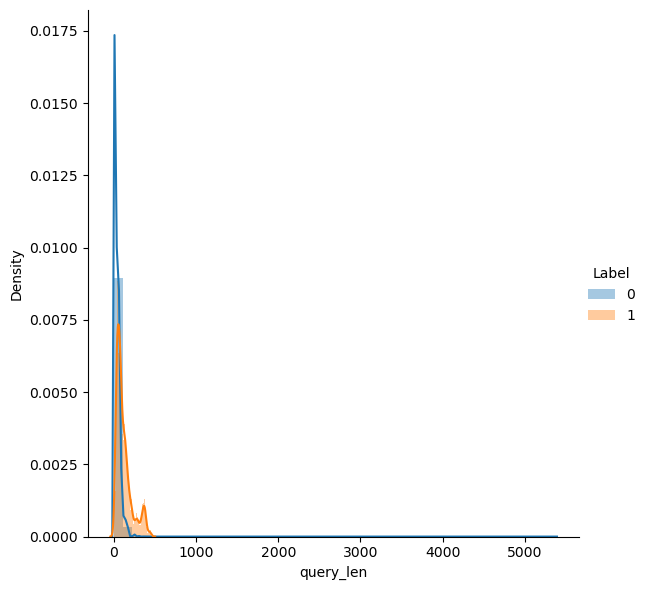

In [100]:
#checking the distribution
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "query_len") \
   .add_legend()

plt.show()

###### Observations:
###### There is more overlap between label 1 and label 0 query lengths.
###### It is hard to distingish between sql and sql injection queries

#### Applying transformations¶

###### Above distribution looks like lognormal distribution we will apply two transformations to see they can be converted to guassian distributions are not. - Logarithmic transformations. - Box cox transformations.¶

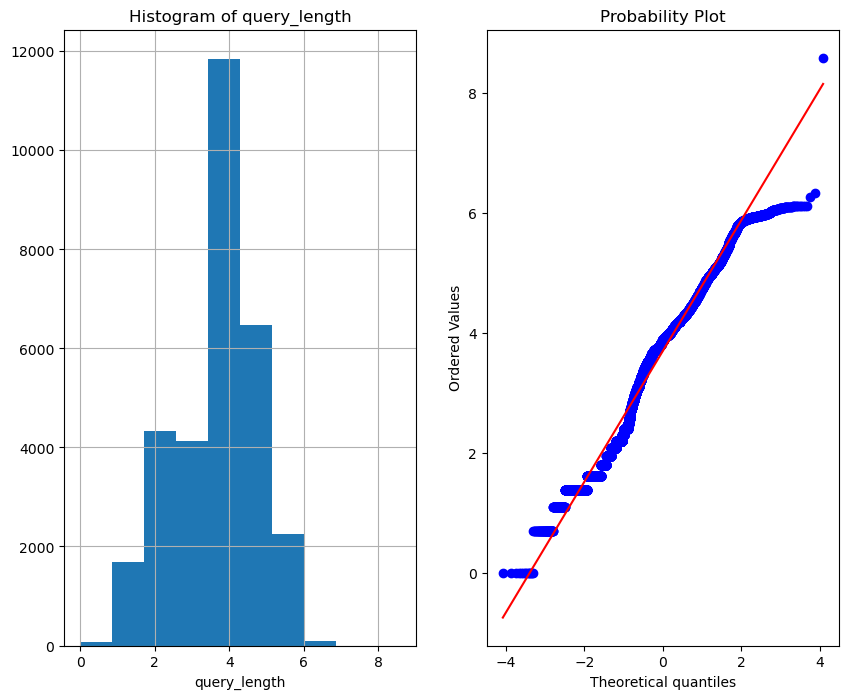

In [105]:
#logarithmic transformation
#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
np.log(data['query_len']).hist()
plt.xlabel('query_length')
plt.title("Histogram of query_length")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(np.log(data['query_len']),dist = 'norm',plot = plt)
plt.show()

###### Observations :
###### After applying logarithmic transformations by looking at histogram it is some what looks like guassian distribution but we confirm it using Q-Q plots.
###### By looking at Q-Q plots it is not fully guassian distributed. some points in left and right are skewed.

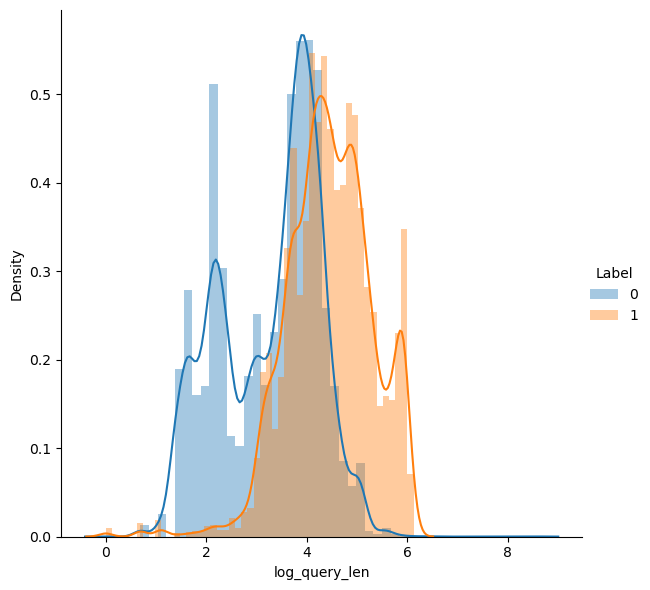

In [108]:
#checking the distribution of log transformed values to see if they actually differntiate between labels
data['log_query_len'] = data['query_len'].apply(lambda x : np.log(x))
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "log_query_len") \
   .add_legend()

plt.show()

###### -The above distribution shows There is slight overlap between label classes so we avoid taking log transformed values for Model building

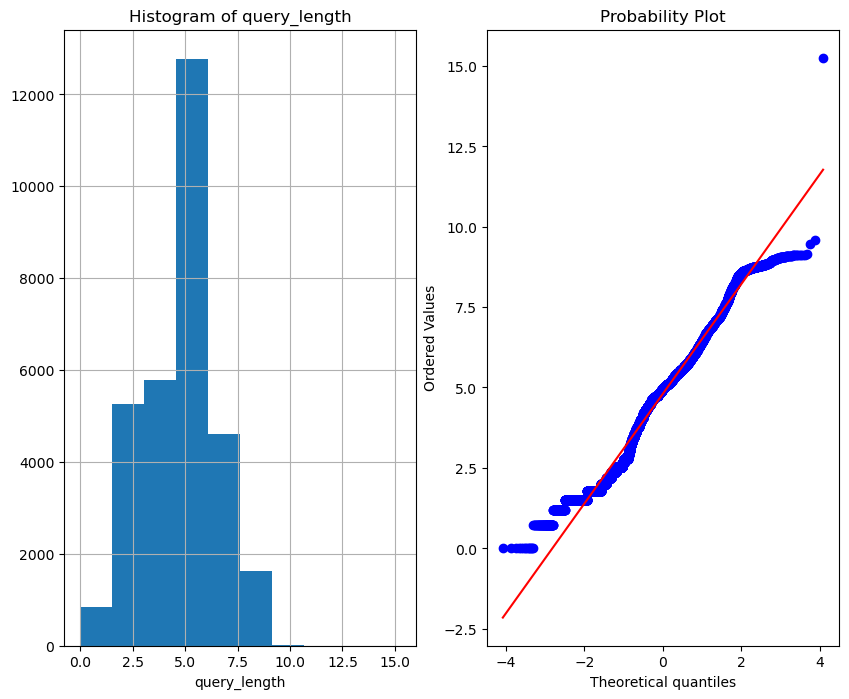

In [111]:
#box-cox transformations
x,lamb = boxcox(data['query_len'],lmbda = None)


#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
pd.Series(x).hist()
plt.xlabel('query_length')
plt.title("Histogram of query_length")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(x,dist = 'norm',plot = plt)
plt.show()

###### From the above box-cox transformations we can observe that the distribution is not perfectly Guassian

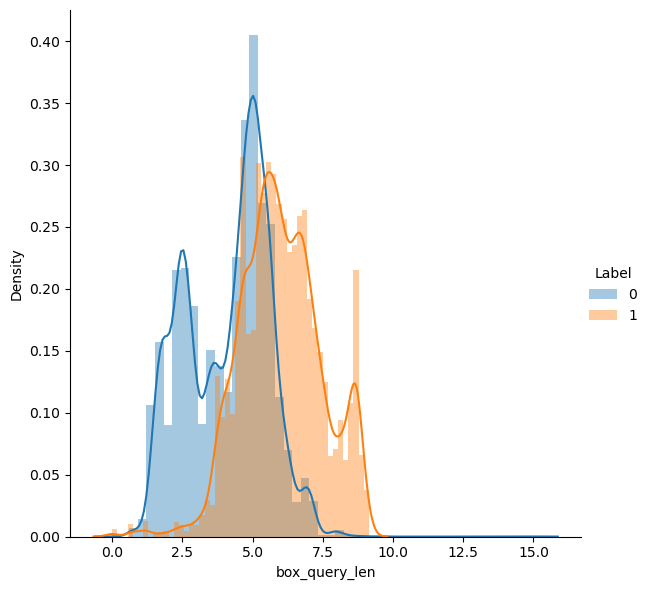

In [114]:
#checking the distribution of box cox transformed values to see if they actually differntiate between labels
data['box_query_len'] = x
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "box_query_len") \
   .add_legend()

plt.show()

###### The box cox transformed values also have slight overlap so we avoid taking these values for model building

#### num_words_query : Number of words in a query

In [118]:
#num_words_query
data['num_words_query'].describe()

count    30903.000000
mean        12.420445
std         14.930125
min          0.000000
25%          4.000000
50%          9.000000
75%         14.000000
max        216.000000
Name: num_words_query, dtype: float64

###### Observations:

###### The minimum value of words is 0 but it should not be zero so will further check the particular query.
###### maximum and mean values are 216 and 12

#### Filtering out the queries which have zero words and removing them from datset

In [122]:
#from above stats we can see that minimum number of word found is zero so it should not be zero.
#will find the query which is having num_word_query as zero
#num_words_query
data[data['num_words_query'] == 0]

,Query,Label,query_len,num_words_query,no_single_qts,no_double_qts,no_punct,no_single_cmnt,no_mult_cmnt,no_space,...,no_log_opt,no_arith,no_null,no_hexa,no_alpha,no_digit,len_of_chr_char_null,genuine_keywords,log_query_len,box_query_len
19323,,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.0,0.0


In [124]:
#above we can see that index 19323 is having that query.
#let's examine the query.

data['Query'][19323]

' '

In [126]:
#we can see it does not contain any query will drop the above query.

data = data.drop(index = 19323).reset_index(drop=True)

In [128]:
data.head()

,Query,Label,query_len,num_words_query,no_single_qts,no_double_qts,no_punct,no_single_cmnt,no_mult_cmnt,no_space,...,no_log_opt,no_arith,no_null,no_hexa,no_alpha,no_digit,len_of_chr_char_null,genuine_keywords,log_query_len,box_query_len
0,""" or pg_sleep ( __time__ ) --",1,33,7,0,1,10,1,0,6,...,1,2,0,0,13,0,0,0,3.496508,4.369491
1,create user name identified by pass123 tempora...,1,90,12,0,0,1,0,0,11,...,0,0,0,0,75,3,0,0,4.499810,6.011679
2,and 1 = utl_inaddr.get_host_address ( ...,1,218,35,3,0,25,0,0,35,...,2,0,0,0,120,2,0,2,5.384495,7.637896
3,select * from users where id = '1' or @ @1 ...,1,90,20,3,0,13,1,0,20,...,1,3,0,0,42,5,0,2,4.499810,6.011679
4,"select * from users where id = 1 or 1#"" ( ...",1,85,18,0,1,10,1,0,18,...,1,3,0,0,42,4,0,2,4.442651,5.912577


In [130]:
data.shape

(30902, 21)

In [132]:
#since we have removed certain amount of data will store it in csv file that will be useful further
data.to_csv('feature_extracted_1.csv')

In [134]:
data['num_words_query'].describe()

count    30902.000000
mean        12.420847
std         14.930199
min          1.000000
25%          4.000000
50%          9.000000
75%         14.000000
max        216.000000
Name: num_words_query, dtype: float64

#### Violin plot: Number of words in a query vs Labels

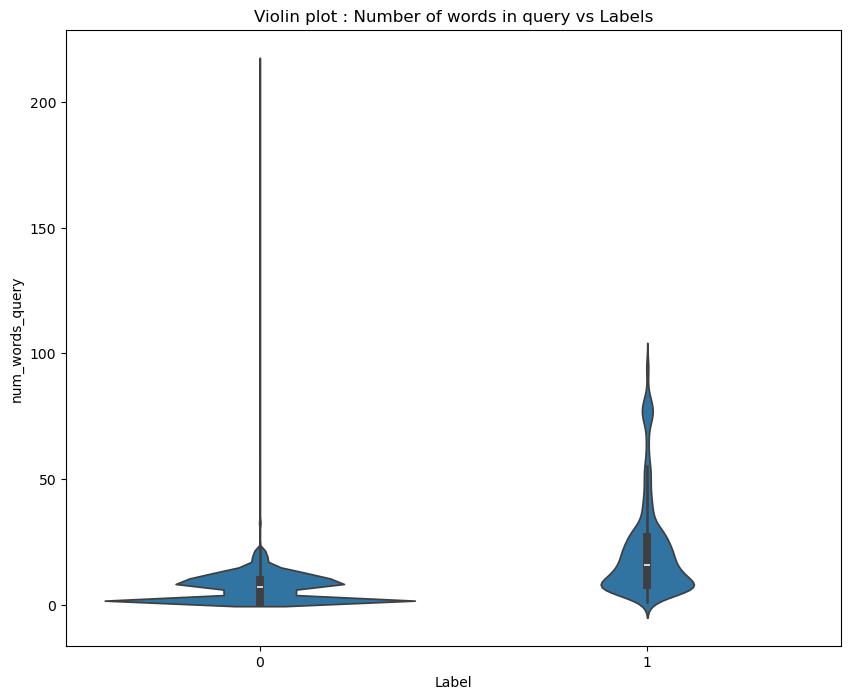

In [139]:
#num_words_query\
#number of words in a query
#violin plots
plt.figure(figsize = (10,8))


sns.violinplot(x = data['Label'],y = data['num_words_query'],data=data)

plt.title("Violin plot : Number of words in query vs Labels")
plt.show()

#### Distribution plot of number of words in a query

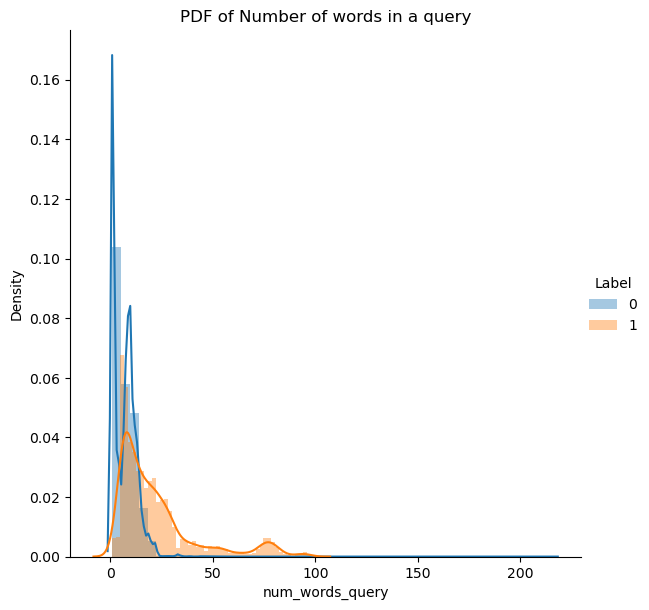

In [142]:
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "num_words_query") \
   .add_legend()

plt.title("PDF of Number of words in a query")
plt.show()

###### Observation:

###### The distribution shows that there is a overlap between labels.
###### If the number of words > 50 we can say it is sqli query but it is not perfect.

#### Applying Transformations

###### Above distribution looks like Log normal distribution will check that can we convert it to guassian distribution. By applying
###### Lograthmic transformations.
###### Box cox Transformations.

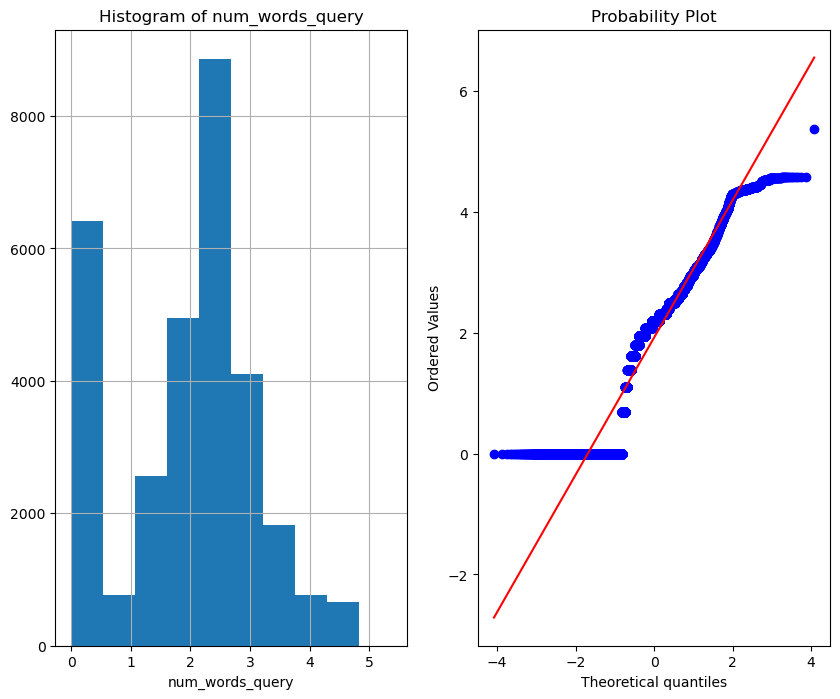

In [147]:
#logarithmic transformation
#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
np.log(data['num_words_query']).hist()
plt.xlabel('num_words_query')
plt.title("Histogram of num_words_query")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(np.log(data['num_words_query']),dist = 'norm',plot = plt)
plt.show()

###### Observations -

###### The histogram is more right skewed and does not look like perfect guassian distribution.

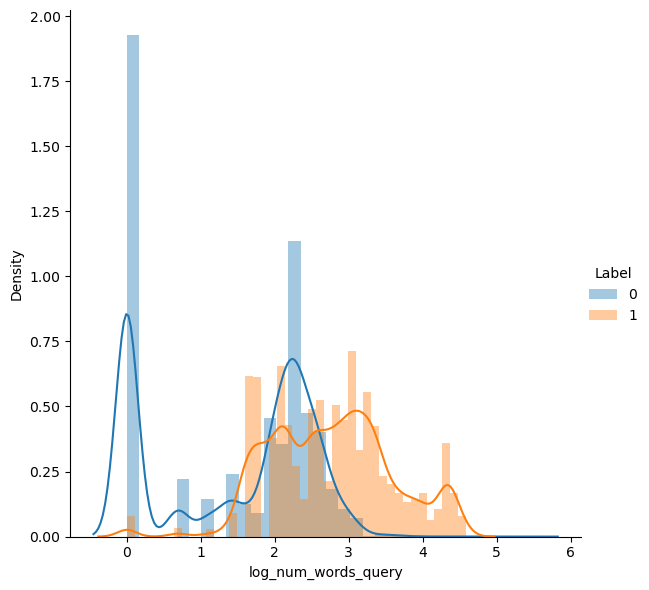

In [150]:
#checking the distribution of log transformed values to see if they actually differntiate between labels
data['log_num_words_query'] = data['num_words_query'].apply(lambda x : np.log(x))
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "log_num_words_query") \
   .add_legend()

plt.show()

###### -Distribution shows that there is a high overlap between the label classes so we avoid taking these values

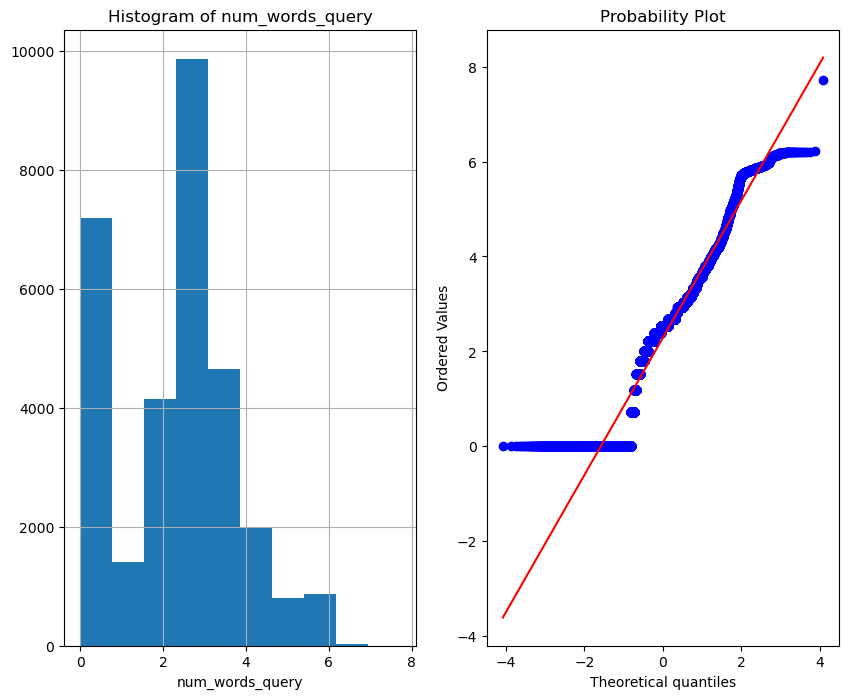

In [155]:
#box-cox transformations
x,lamb = boxcox(data['num_words_query'],lmbda = None)


#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
pd.Series(x).hist()
plt.xlabel('num_words_query')
plt.title("Histogram of num_words_query")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(x,dist = 'norm',plot = plt)
plt.show()


#### The distribution looks same as lograthmic transformation distribution above.

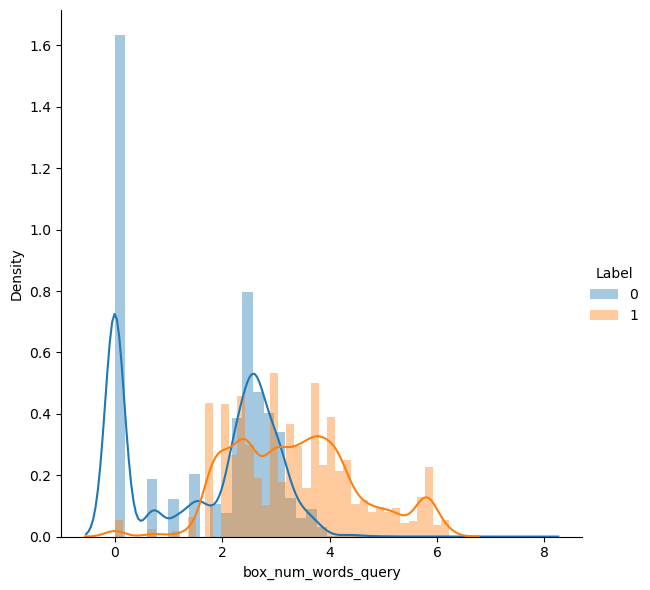

In [160]:
#checking the distribution of box cox transformed values to see if they actually differntiate between labels
data['box_num_words_query'] = x
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "box_num_words_query") \
   .add_legend()

plt.show()

###### Same there is a high overlap between classes so we avoid taking these values

#### no_single_qts : number of single quotations in a query

In [164]:
data['no_single_qts'] .describe()

count    30902.000000
mean         0.833927
std          1.664176
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         13.000000
Name: no_single_qts, dtype: float64

###### Observations :

###### There are queries which does not have single quotes at all so minimum is zero and maximum single quotes in a query is 13

#### Violin plot : num_single_qts vs labels

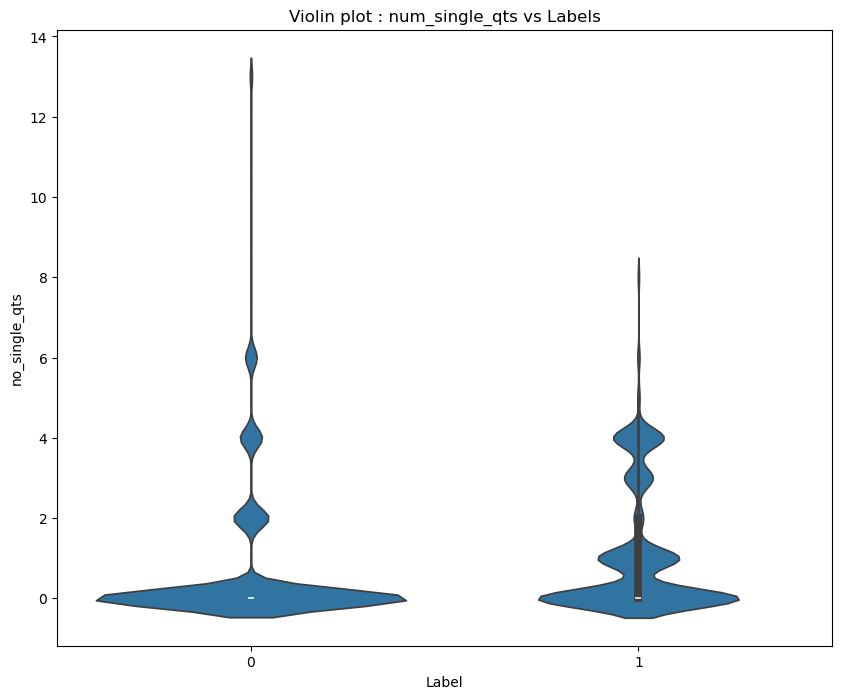

In [169]:
#no_single_qts
#number of single quotation.

plt.figure(figsize = (10,8))

sns.violinplot(x = data['Label'],y = data['no_single_qts'],data=data)

plt.title("Violin plot : num_single_qts vs Labels")
plt.show()

###### Observations:

###### The label 0 percentile values are not visible will examine further by plotiing boxplots.

#### Box plot of num_single_qts vs labels

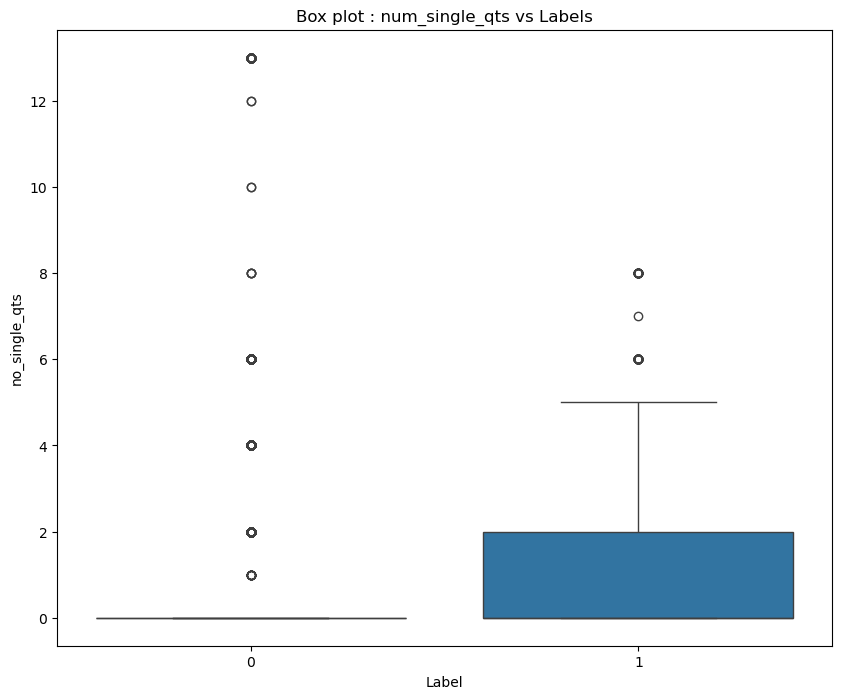

In [174]:
plt.figure(figsize = (10,8))

sns.boxplot(x = data['Label'],y = data['no_single_qts'],data=data)

plt.title("Box plot : num_single_qts vs Labels")
plt.show()

###### Observations:

###### We can confirm that 25,50 and 75 pernetile values of label 0. i.e sql queries are 0. it means sql queries have less single quotes than sql injection queries.
###### This feature will help in distinguish between label 0 and label 1 values as there is no much overlap between them.
###### will check further by plotting distribution to see the amount of overlap if possible we can write rule based model.

#### Distribution of num_single_qts

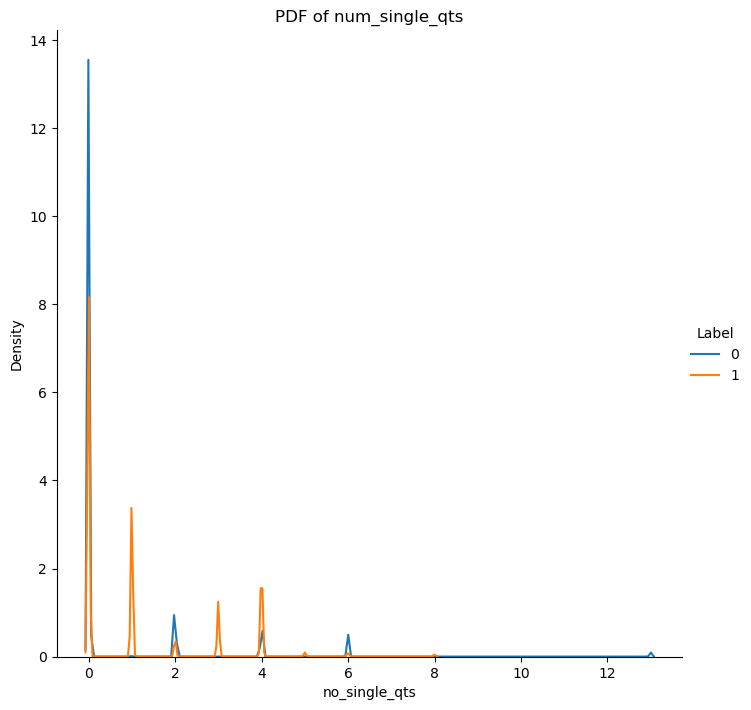

In [182]:
# Plotting PDF
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.kdeplot, "no_single_qts", bw_adjust=0.1) \
   .add_legend()
plt.title("PDF of num_single_qts")
plt.show()


###### Observations :

###### We can see when number of single quotations are 1 and 3 the the queries will be sql injection.

###### when the number of single quotations are 6 or some what 12 the queries are normal or genuine sql queries.

###### there is slight overlap.

###### we can write a rule based model like this

                   ###### if(no_single_qts == 1 and no_single_qts == 3):
                   ######       then it is label 1 i.e sql injection query.
                   ###### else if(no_single_qts == 6 and no_single_qts == 12):
                   ######        then it is label 0 i.e sql query.

####  no_double_qts : Number of double quotations in a query

In [187]:
#no_double_qts
#number of double quotes in a query

data['no_double_qts'].describe()

count    30902.000000
mean         0.256844
std          0.863606
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: no_double_qts, dtype: float64

###### Double quotes lies in range of 0 to 20

#### Countplot of num_double_qts va Labels

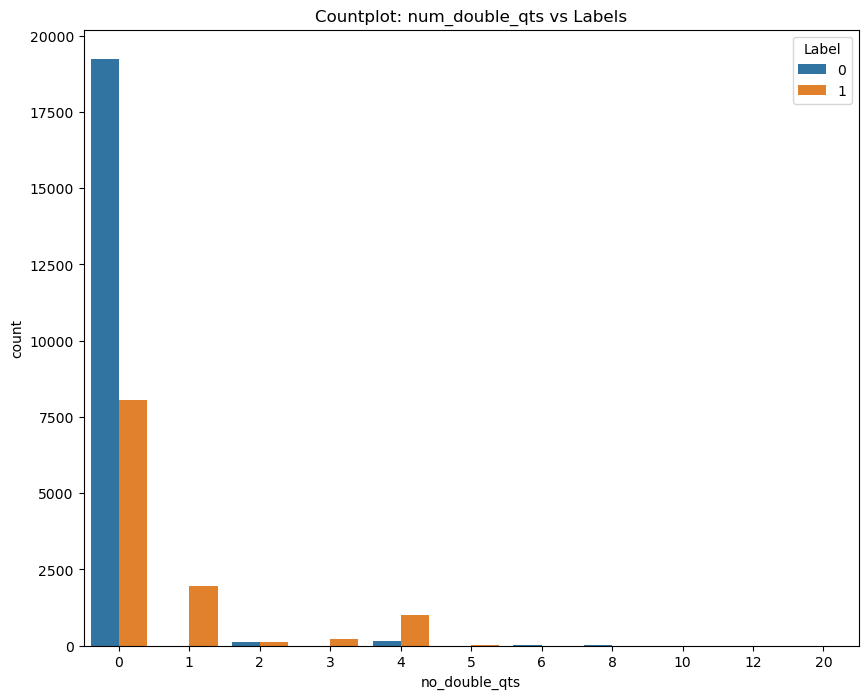

In [191]:
plt.figure(figsize = (10,8))

sns.countplot(x = data['no_double_qts'],hue = data['Label'],data=data)

plt.title("Countplot: num_double_qts vs Labels")
plt.show()

###### Observations :

###### maximum number of queries does not have double quotes.
###### if number of queries are 1 and 3 then it is more likely to be sql injection query.

#### Box plot : num_double_qts vs Labels

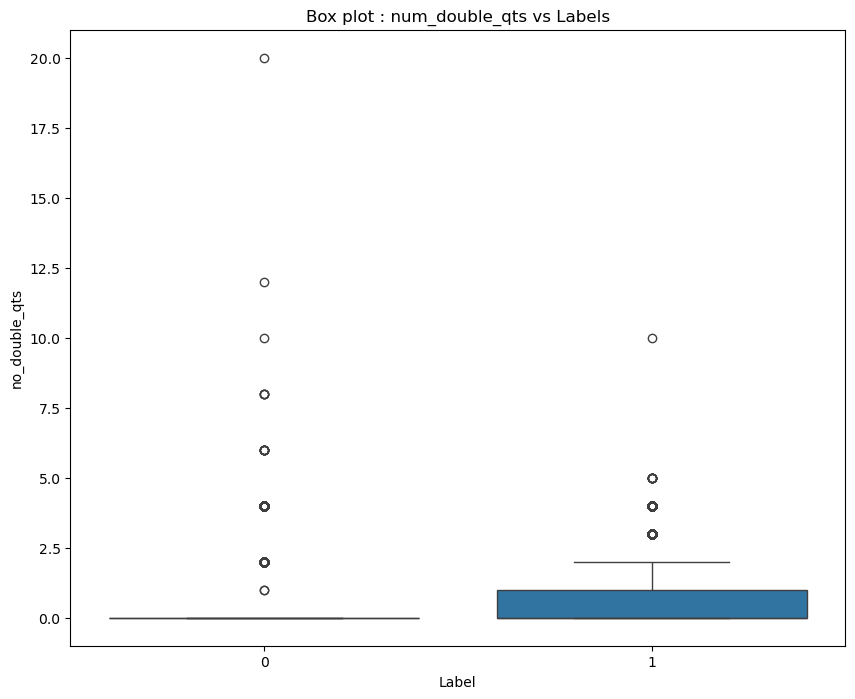

In [195]:
plt.figure(figsize = (10,8))

sns.boxplot(x = data['Label'],y = data['no_double_qts'],data=data)

plt.title("Box plot : num_double_qts vs Labels")
plt.show()

#### no_punct : Number of punctuations in a query

In [198]:
#no_punct
data['no_punct'].describe()

count    30902.000000
mean         7.969322
std         12.340108
min          0.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        595.000000
Name: no_punct, dtype: float64

###### some queries does not have punctuations at all and it lies in the range of 0 to 595

#### count plot : no_punct vs labels

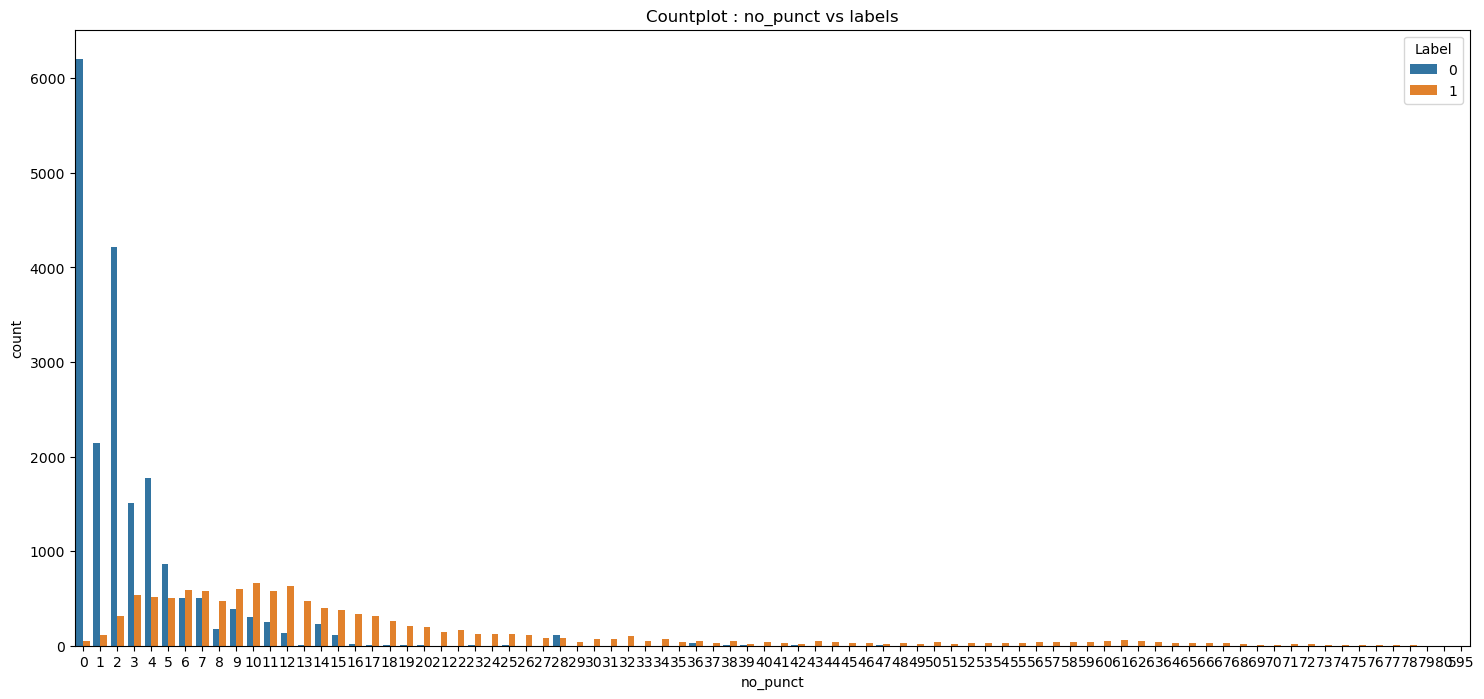

In [202]:
#no_punct
#number of punctuations in a query.

plt.figure(figsize = (18,8))

sns.countplot(x = data['no_punct'],hue = data['Label'],data=data)

plt.title("Countplot : no_punct vs labels")
plt.show()

###### Observations :

###### Most of the queries does not have punctuations at all
###### there is some slight overlap till the number of punctuations are 16 or 17. after that as the punctuations increases there is a high chances of it being a sql injection query.

In [205]:
#no_single_cmnt
#number of single comments
data['no_single_cmnt'].describe()

count    30902.000000
mean         0.128535
std          0.334690
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: no_single_cmnt, dtype: float64

###### Almost all the queries either have the single line comment or it does not have it. the maximum a query can have single comment is 1

#### Countplot : no_single_cmnt vs labels

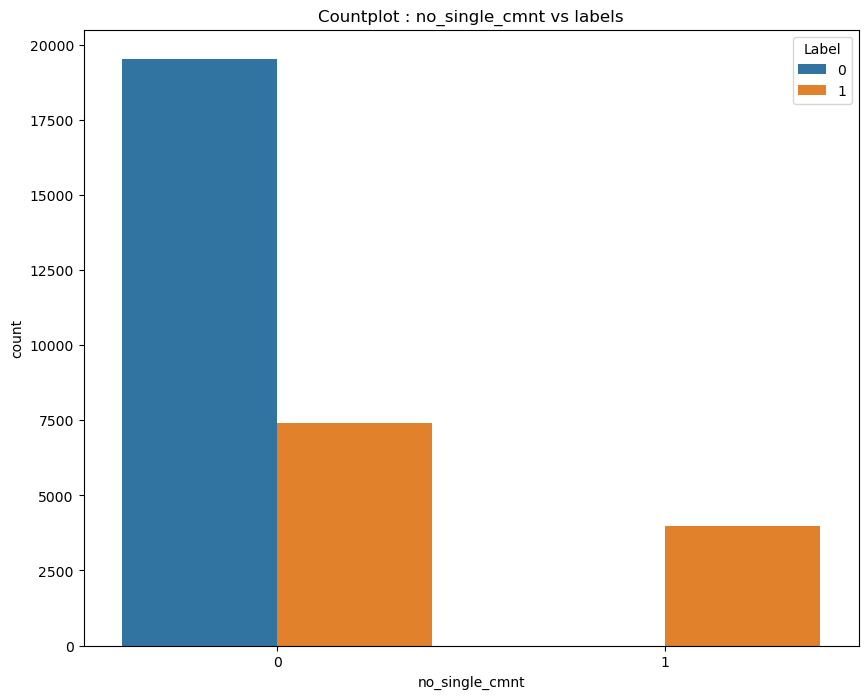

In [209]:
plt.figure(figsize = (10,8))

sns.countplot(x = data['no_single_cmnt'],hue = data['Label'],data=data)

plt.title("Countplot : no_single_cmnt vs labels")
plt.show()

###### Observations:

###### It is very clear from above plot if the number of single comment is 1 then it is a sql injection query.
###### we can write rule base model like this: if(no_single_cmnt == 1): then label 1 else: label 0

####  no_mult_cmnt : Number of multi line comment in a query

In [213]:
#no_mult_cmnt
#number of multiline comments
data['no_mult_cmnt'].describe()

count    30902.000000
mean         0.000971
std          0.037722
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: no_mult_cmnt, dtype: float64

#### count plot : no_mult_cmnt vs labels

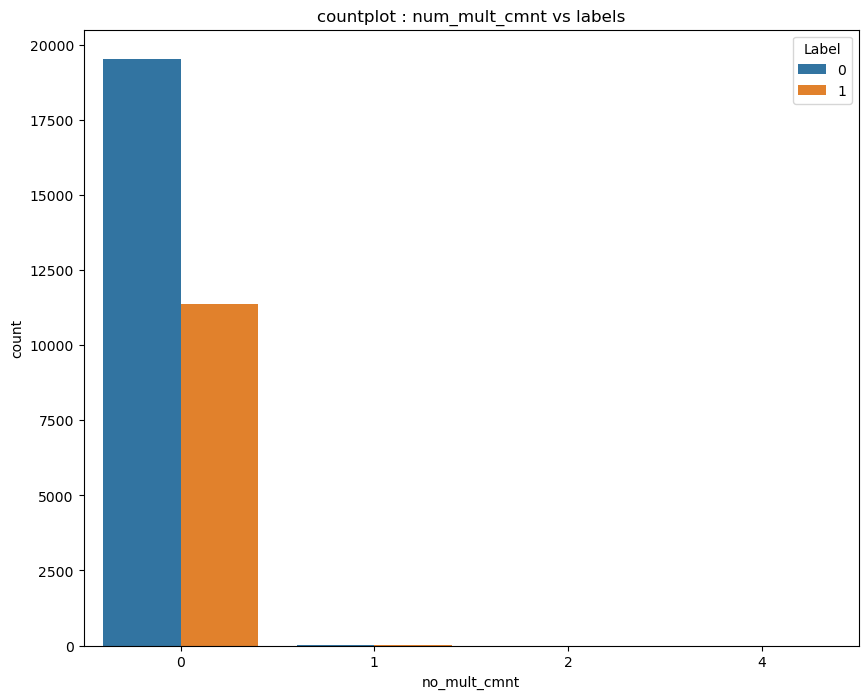

In [216]:
plt.figure(figsize = (10,8))

sns.countplot(x=data['no_mult_cmnt'],hue = data['Label'],data=data)

plt.title("countplot : num_mult_cmnt vs labels")
plt.show()

###### Observations:

###### most of the queries does not have multi line comments and very less number of queries have multi line comments if a query having a multi line comment then it is a sql injection query.

#### no_space : number of white spaces in a query

In [220]:
#no_space
#number of white space in query
data['no_space'].describe()

count    30902.000000
mean        11.594395
std         14.964074
min          0.000000
25%          3.000000
50%          8.000000
75%         14.000000
max        215.000000
Name: no_space, dtype: float64

####  Countplot : no_space vs labels

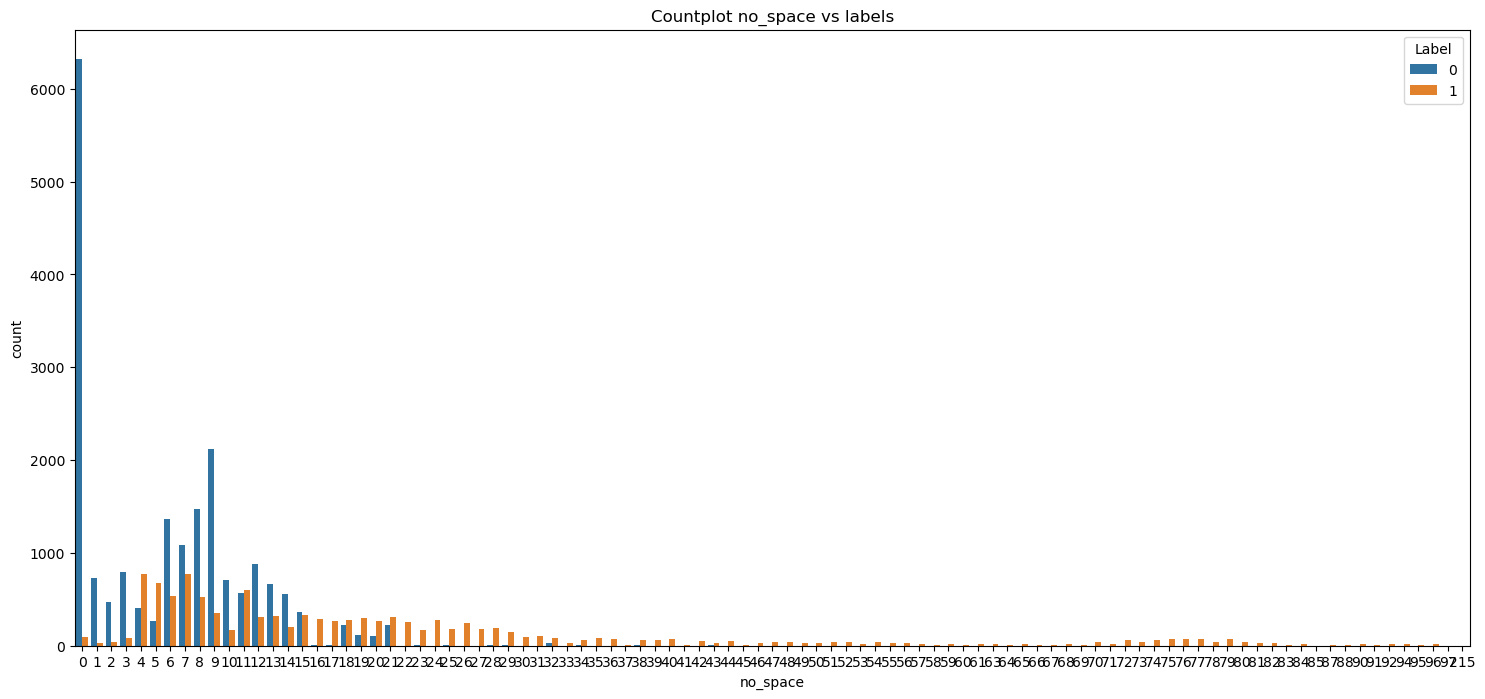

In [223]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_space'],hue = data['Label'],data=data)

plt.title("Countplot no_space vs labels")
plt.show()

###### Observation :

###### it is hard to analyze as number of spaces i.e count is more but we can see that there is a slight overlap till 21. after that as the number of white spaces increased the chances of query becoming a sql injection query also increases.
###### We will analyze it through distribution plots.

#### Distribution of number of spaces

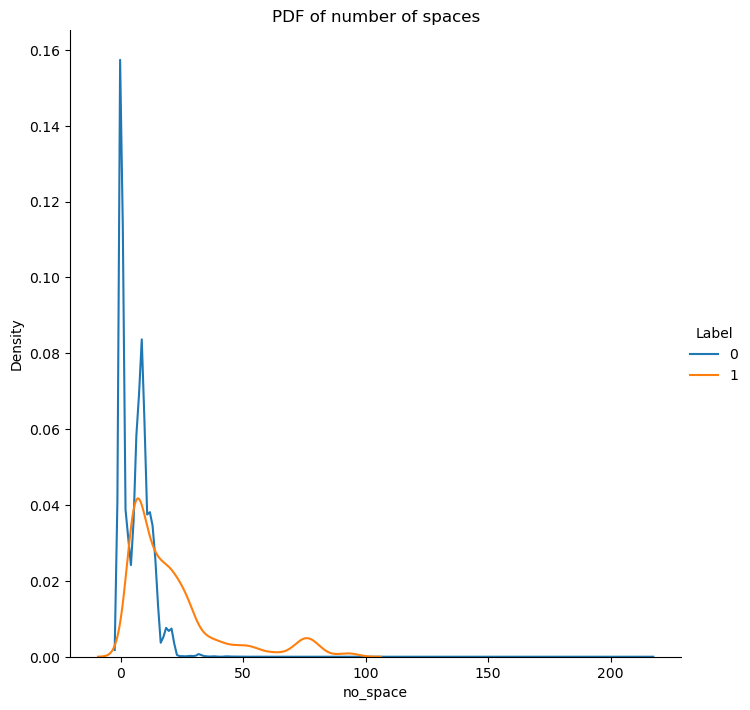

In [229]:
# Plotting PDF
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.kdeplot, "no_space") \
   .add_legend()

plt.title("PDF of number of spaces")
plt.show()


###### We can see there is slight overlap till 24 or 25.
###### as spaces increases after 25 the chances of a query becoming a sql injection query also high

#### Applying Logarithmic and Box cox transforms

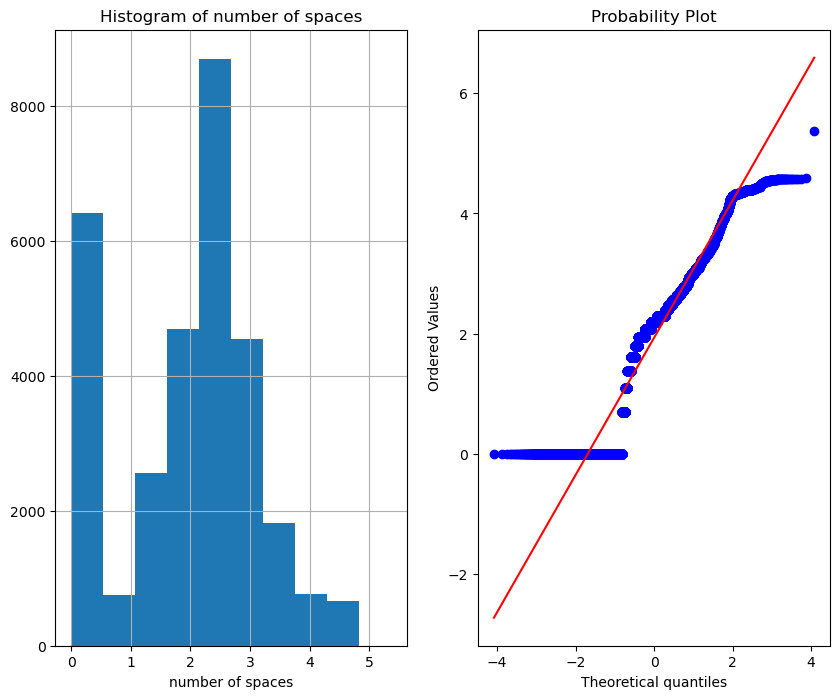

In [233]:
#logarithmic transformation
#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
np.log(data['no_space'] +1 ).hist()
plt.xlabel('number of spaces')
plt.title("Histogram of number of spaces")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(np.log(data['no_space']+1),dist = 'norm',plot = plt)
plt.show()

###### The distribution is right skewed it is not perfect Guassian distribution

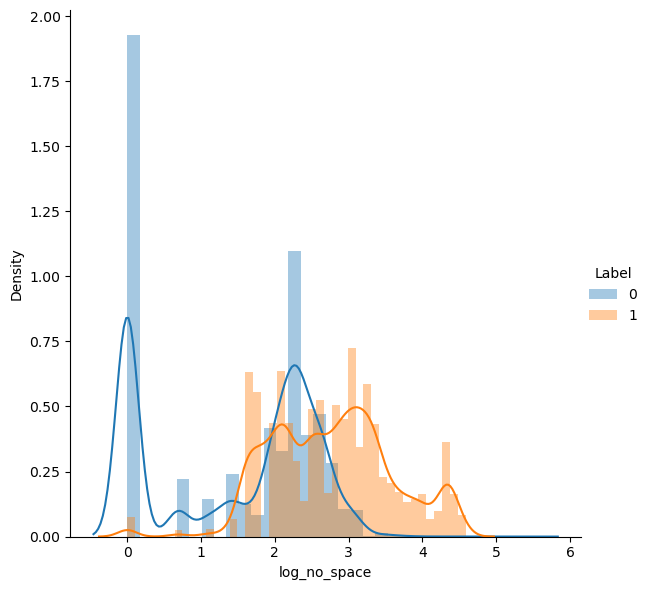

In [238]:
#checking the distribution of log transformed values to see if they actually differntiate between labels
data['log_no_space'] = data['no_space'].apply(lambda x : np.log(x+1))
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "log_no_space") \
   .add_legend()

plt.show()

###### The distribution shows there is a overlap between the label classes so we avoid taking the values

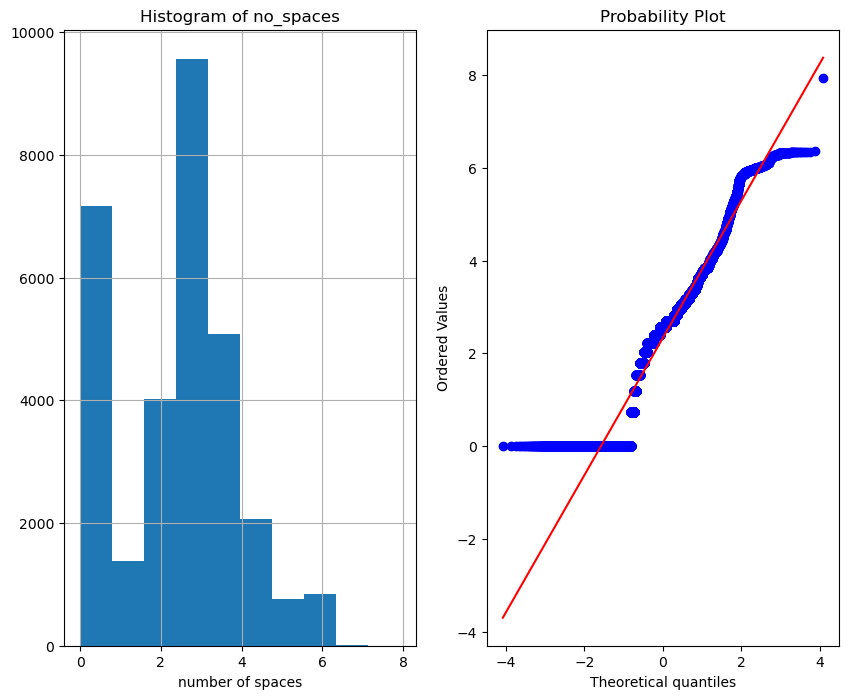

In [241]:
#box-cox transformations
x,lamb = boxcox(data['no_space']+1,lmbda = None)


#histogram
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
pd.Series(x).hist()
plt.xlabel('number of spaces')
plt.title("Histogram of no_spaces")

#Q-Q plot to verify the distribution is guassian or not.
plt.subplot(1,2,2)
stats.probplot(x,dist = 'norm',plot = plt)
plt.show()

###### No diiference between logarithmic and box cox transformation as we can see it from the above plots

#checking the distribution of box cox transformed values to see if they actually differntiate between labels
data['box_no_space'] = x
sns.FacetGrid(data, hue="Label",height = 6) \
   .map(sns.distplot, "box_no_space") \
   .add_legend()

plt.show()


###### The distribution shows there is overlap between classes so we avoid taking the values

#### no_perc : Number of percentage(%) Symbols in a query

In [248]:
#no_perc
#number of percentage symbols in a query.
data['no_perc'].describe()

count    30902.000000
mean         0.092874
std          0.377494
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: no_perc, dtype: float64

###### Percentage symbols lies in range of 0 to 8.

#### Countplot : no_perc vs labels

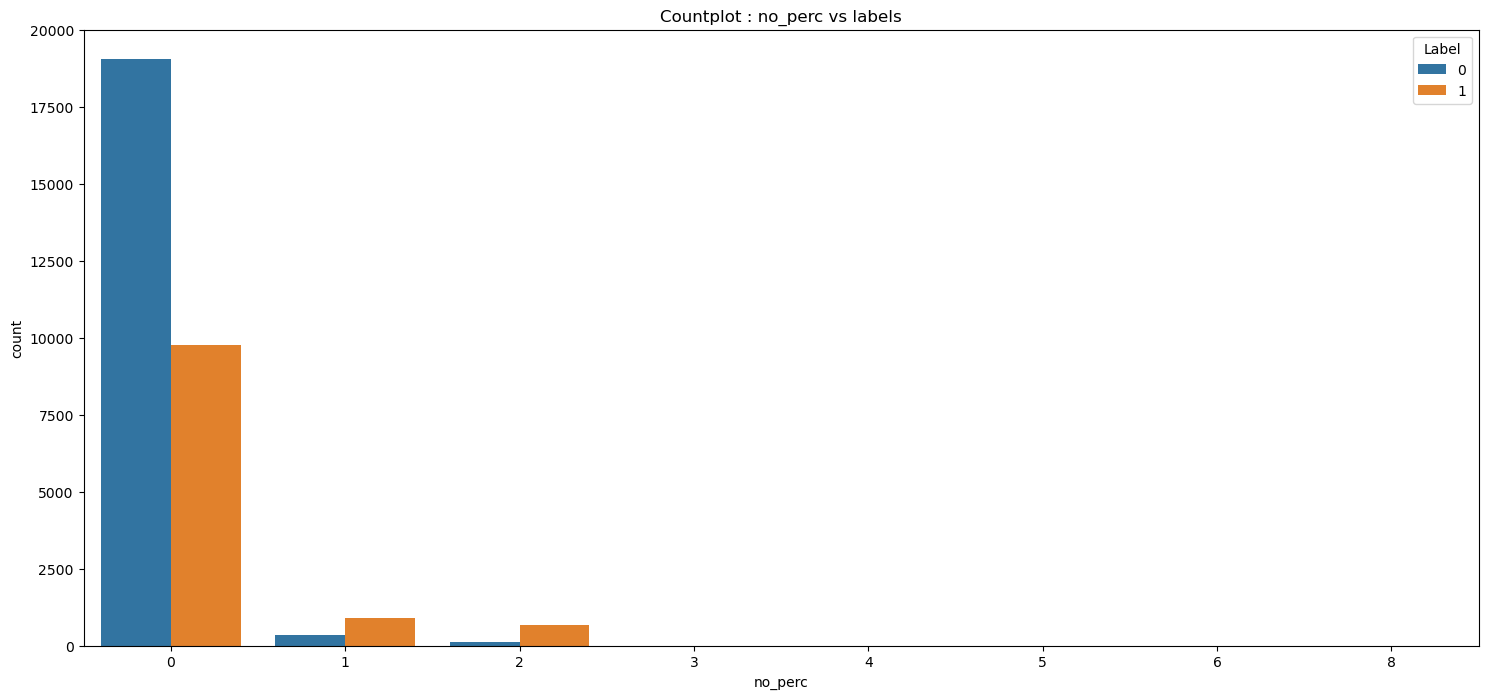

In [253]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_perc'],hue = data['Label'],data=data)

plt.title("Countplot : no_perc vs labels")
plt.show()


####  Distribution of no_perc

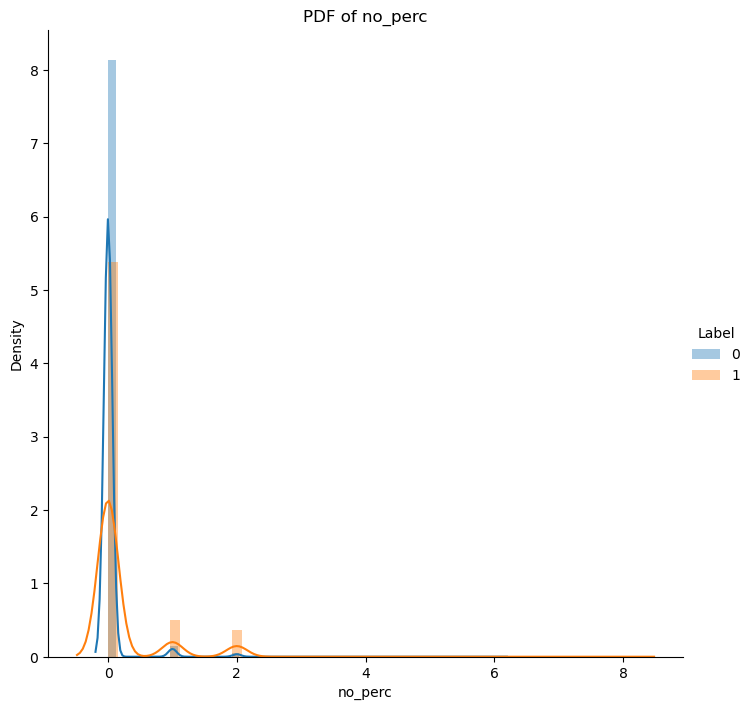

In [258]:
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.distplot, "no_perc",kde_kws = {'bw':0.3}) \
   .add_legend()
plt.title("PDF of no_perc")
plt.show()

###### Observations:

###### Lot of queries does not contain percentage symbols.
###### Only small amount of queries does contain percentage symbols.
###### from the plot we can see that there is a slight overlap till 2. but as the percentage symbols increases chance of a query becoming a sql injection query also increases.

####  no_log_opt : number of logical operators in a query

In [262]:
#no_log_opt
#number of logical operators in a query.
data['no_log_opt'].describe()

count    30902.000000
mean         0.696266
std          1.822316
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         16.000000
Name: no_log_opt, dtype: float64

###### Logical operators lies in the range of 0 to 16.

#### Countplot : no_logical_opt vs labels

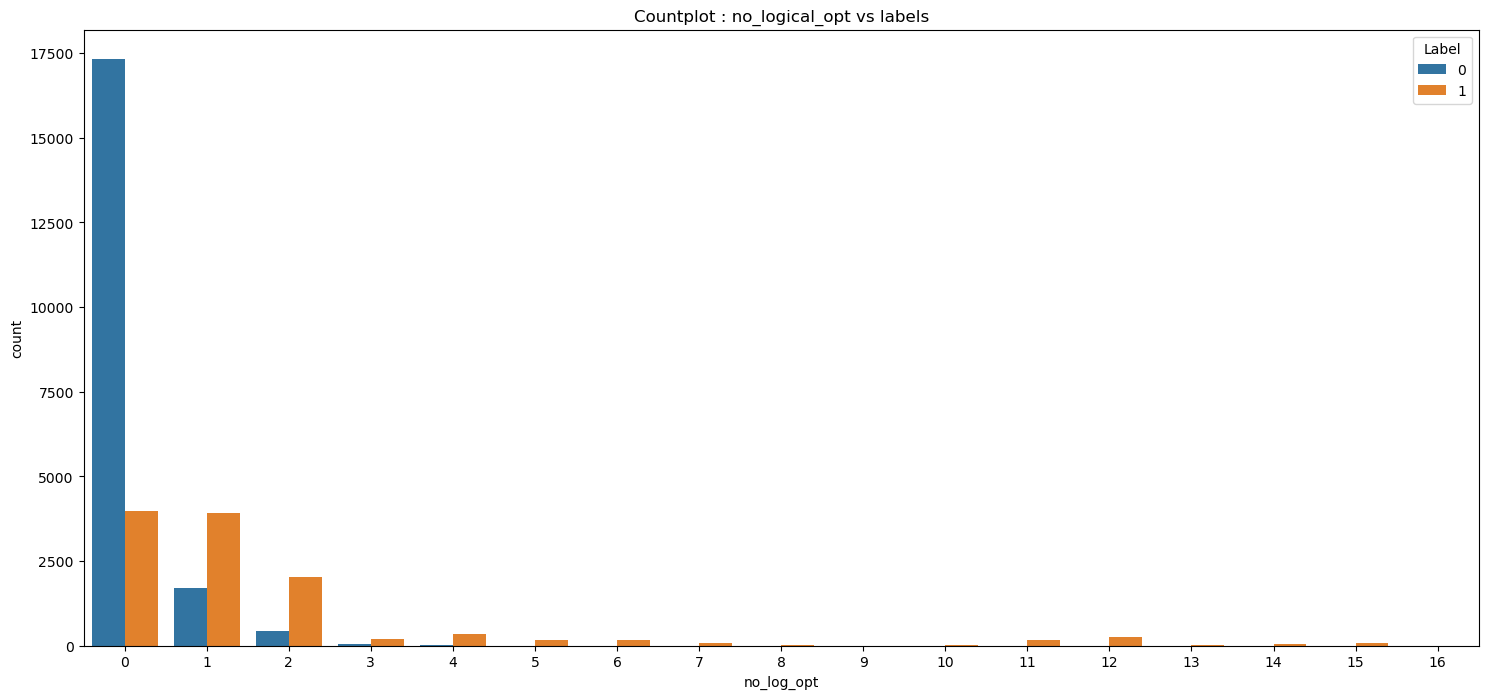

In [266]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_log_opt'],hue = data['Label'],data=data)

plt.title("Countplot : no_logical_opt vs labels")
plt.show()

###### Observations :

###### As we can clearly see from the plot as the number of logical operators increases after 4. then it is sql injection query.
###### most of the queries does not have logical operatoes mainly label 0 queries are most of them.

#### no_arith : Number of arithmetic operators in a query

In [270]:
#no_arith
#number of arithmetic operators in a query.
data['no_arith'].describe()

count    30902.000000
mean         0.880202
std          1.549006
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        117.000000
Name: no_arith, dtype: float64

###### Logical operators lies in range of 0 to 117.

#### Countplot : no_arith vs labels

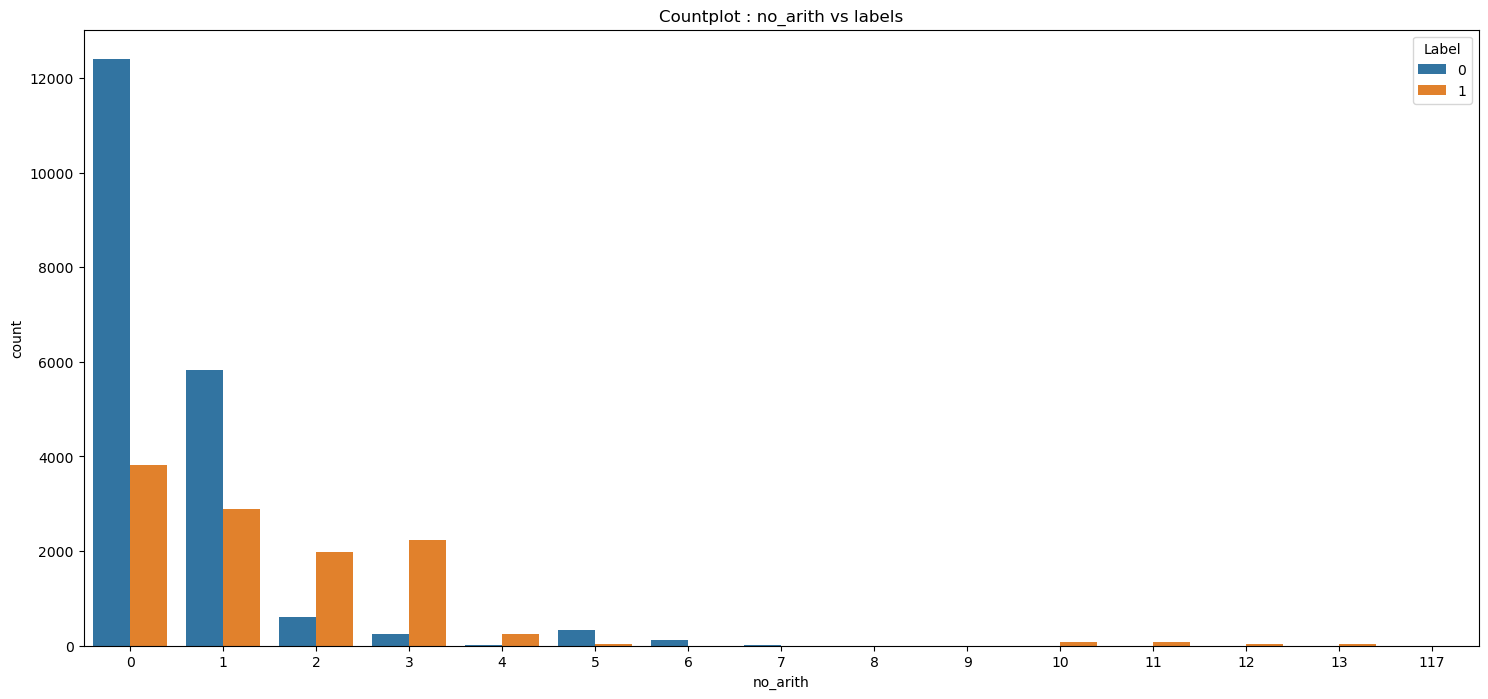

In [275]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_arith'],hue = data['Label'],data=data)

plt.title("Countplot : no_arith vs labels")
plt.show()

###### Observations :

###### From the plot we can observe if the number of arithmetic operators are 4 or greater than 7 then the queries are sql injection queries.
###### Most of the queries have zero arithmetic operators and label 0 queries are most of them.

#### no_null : Number of null values in a query

In [279]:
#no_null
#number of null values in a query.
data['no_null'].describe()

count    30902.000000
mean         0.170960
std          0.975872
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: no_null, dtype: float64

###### Null values in a datset lies in a range of 0 to 10.

#### Countplot : no_null vs labels

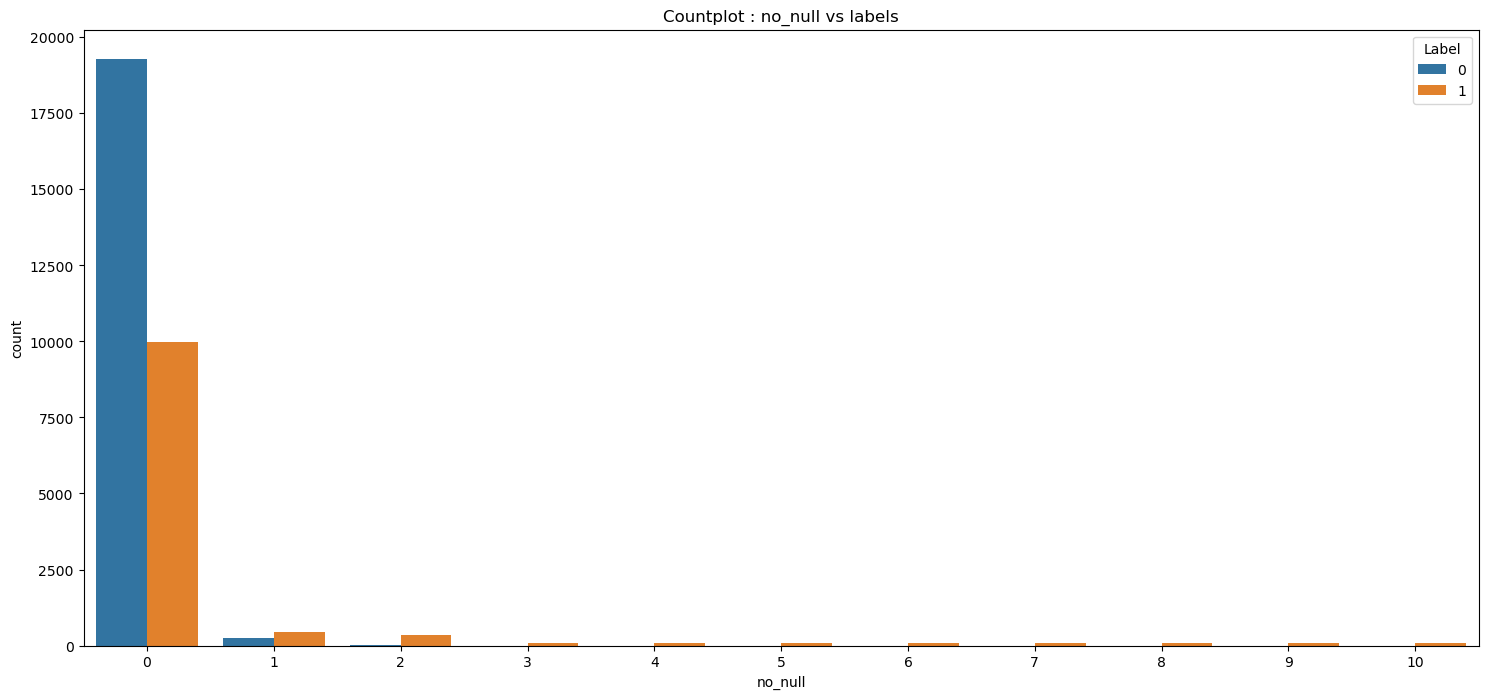

In [283]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_null'],hue = data['Label'],data=data)

plt.title("Countplot : no_null vs labels")
plt.show()

###### Observations :

###### if the number of null values are greater than 2 then it is sql injection query.
###### we had also observed this from wordcloud that null values occurs more in sql injection queries.

####  no_hexa : Number of hexa decimal values in a query

In [287]:
#no_hexa
#number of hexadecimal values.
data['no_hexa'].describe()

count    30902.000000
mean         0.031098
std          0.183554
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: no_hexa, dtype: float64

###### Number of hexa decimal values lie in range of 0 to 11.

#### Countplot : no_hexa vs labels

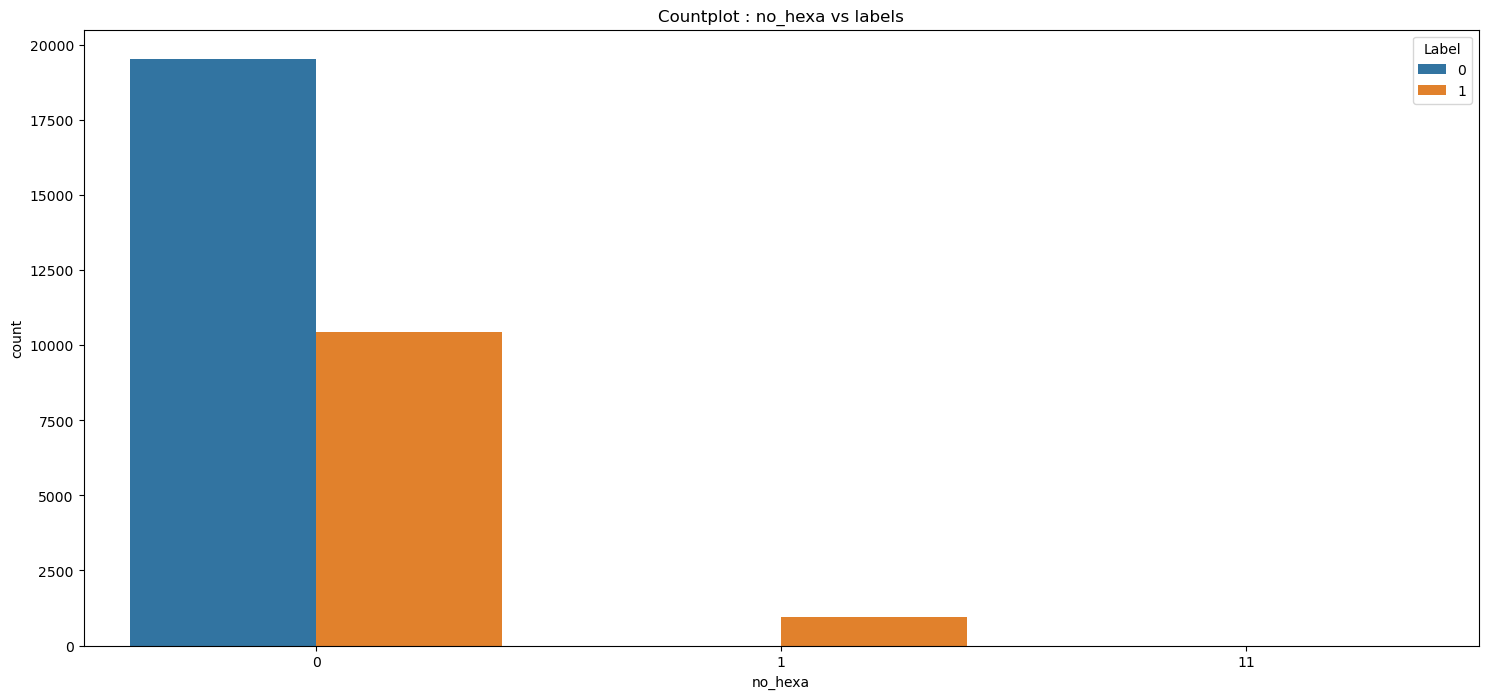

In [291]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_hexa'],hue = data['Label'],data=data)

plt.title("Countplot : no_hexa vs labels")
plt.show()

###### Observations :

###### Most of the queries does not contain hexa decimal values. most of them being label 0 queries.
###### if number of hexa decimal values are greater or equal to 1 then it is sql injection query.

#### no_alpha : Number of alphabets in a query

In [295]:
#no_alpha
#number of alphabets in a query.
data['no_alpha'].describe()

count    30902.000000
mean        32.795127
std         35.460340
min          0.000000
25%         11.000000
50%         28.000000
75%         45.000000
max       3784.000000
Name: no_alpha, dtype: float64

#### Countplot : no_alpha vs labels

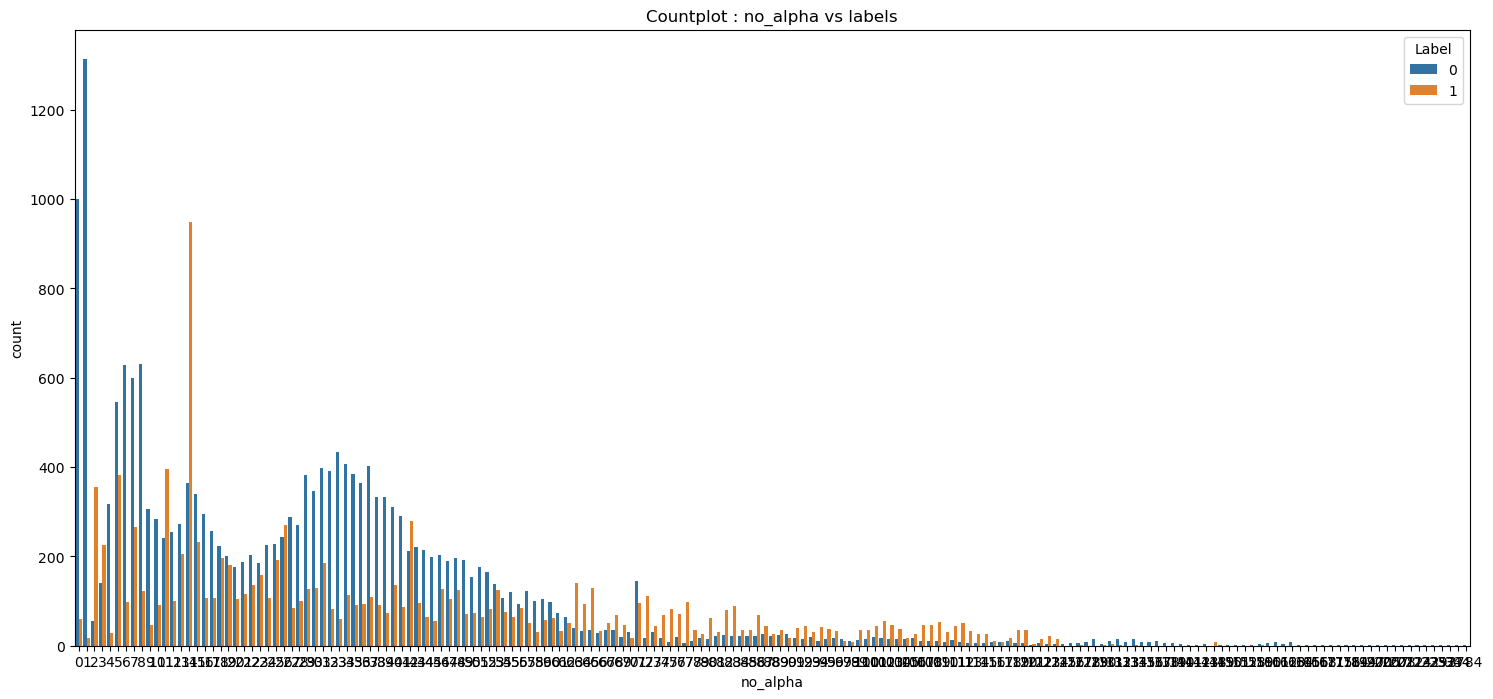

In [298]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_alpha'],hue = data['Label'],data=data)

plt.title("Countplot : no_alpha vs labels")
plt.show()

###### it is hard to analyze from this plot as the number of alphabets are more will check the distribution plots.

#### Distribution of no_alpha

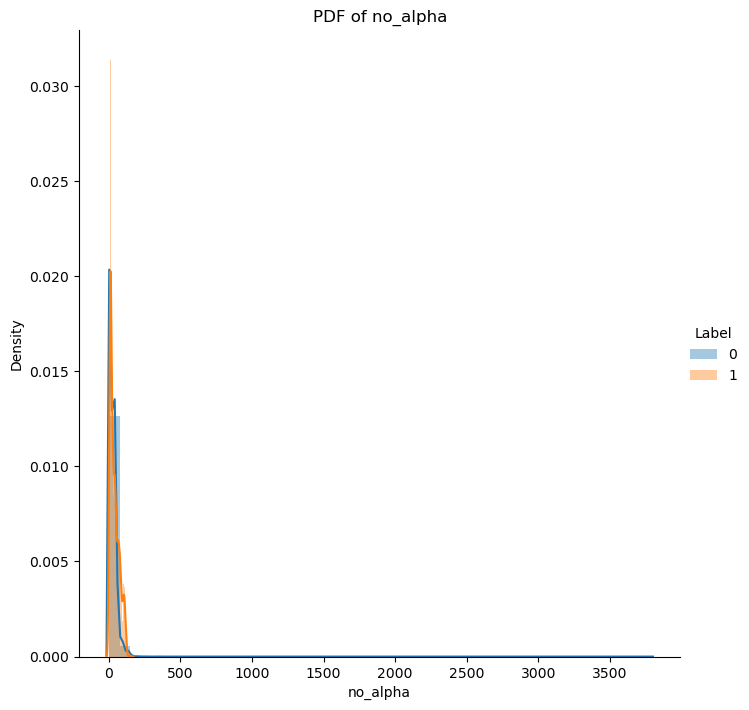

In [304]:
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.distplot, "no_alpha") \
   .add_legend()
plt.title("PDF of no_alpha")
plt.show()

###### Observations :

###### There is a high overlap up to 300.
###### after 300 i.e as the number of alphabets increases the chances of it becoming a sql query also increases.

#### no_digit : number of digits in a query

In [308]:
#no_digit
#number of digits in a query.
data['no_digit'].describe()

count    30902.000000
mean         7.843570
std         13.334089
min          0.000000
25%          0.000000
50%          2.000000
75%          9.000000
max        641.000000
Name: no_digit, dtype: float64

###### Number of digits lie in range of 0 to 641.

#### Countplot : no_digit vs labels

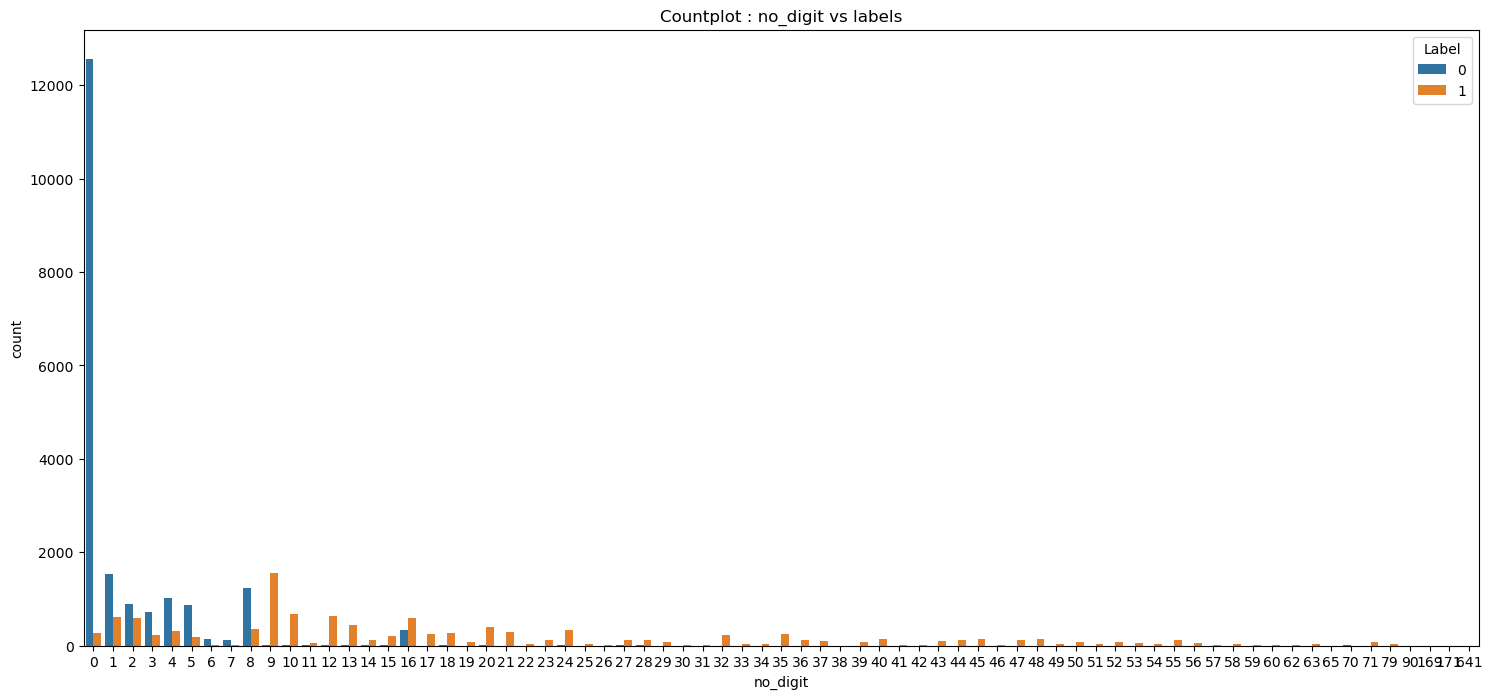

In [314]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['no_digit'],hue = data['Label'],data=data)

plt.title("Countplot : no_digit vs labels")
plt.show()

###### It looks like there is a slight overlap till 18. after that i.e as the number of digit increases chance of it becoming a sql injection query increases.
###### will better understand it by plotting distributions.

#### Distribution of no_digit

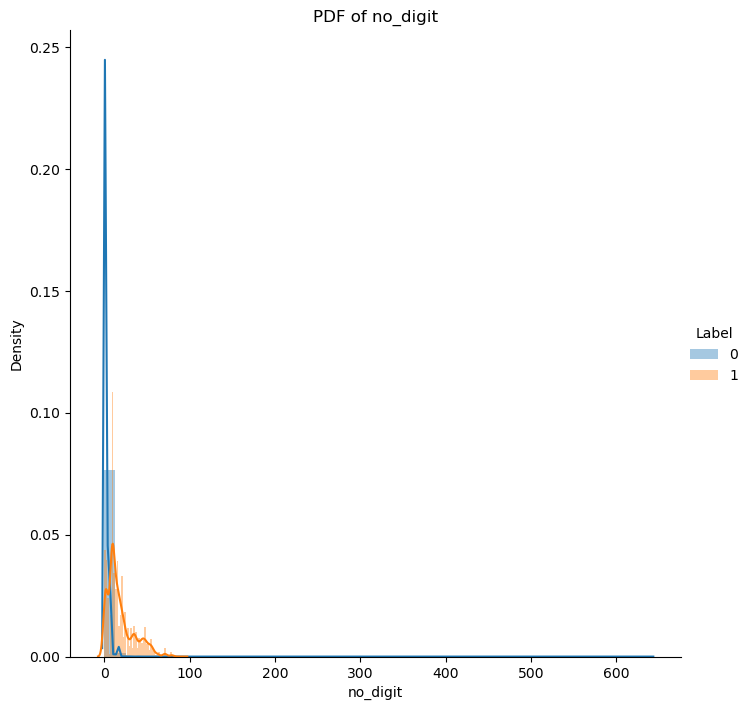

In [322]:
sns.FacetGrid(data, hue="Label", height=7) \
   .map(sns.distplot, "no_digit") \
   .add_legend()
plt.title("PDF of no_digit")
plt.show()

###### Observations :

###### As we can observe from the plot as the number of digit increases the chances of given query becoming a sql injection query also increases.

#### Length of chr,char,null keywords

In [326]:
data['len_of_chr_char_null'].describe()

count    30902.000000
mean         0.576047
std          2.158210
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: len_of_chr_char_null, dtype: float64

###### Observations :

###### The length of these above keywords lies in range of 0 to 13 in a dataset.
###### As we can see 75 percent of queries does not contain these keywords. only less amount of queries contains these keywords.

#### Countplot of Length of chr,char,null keywords

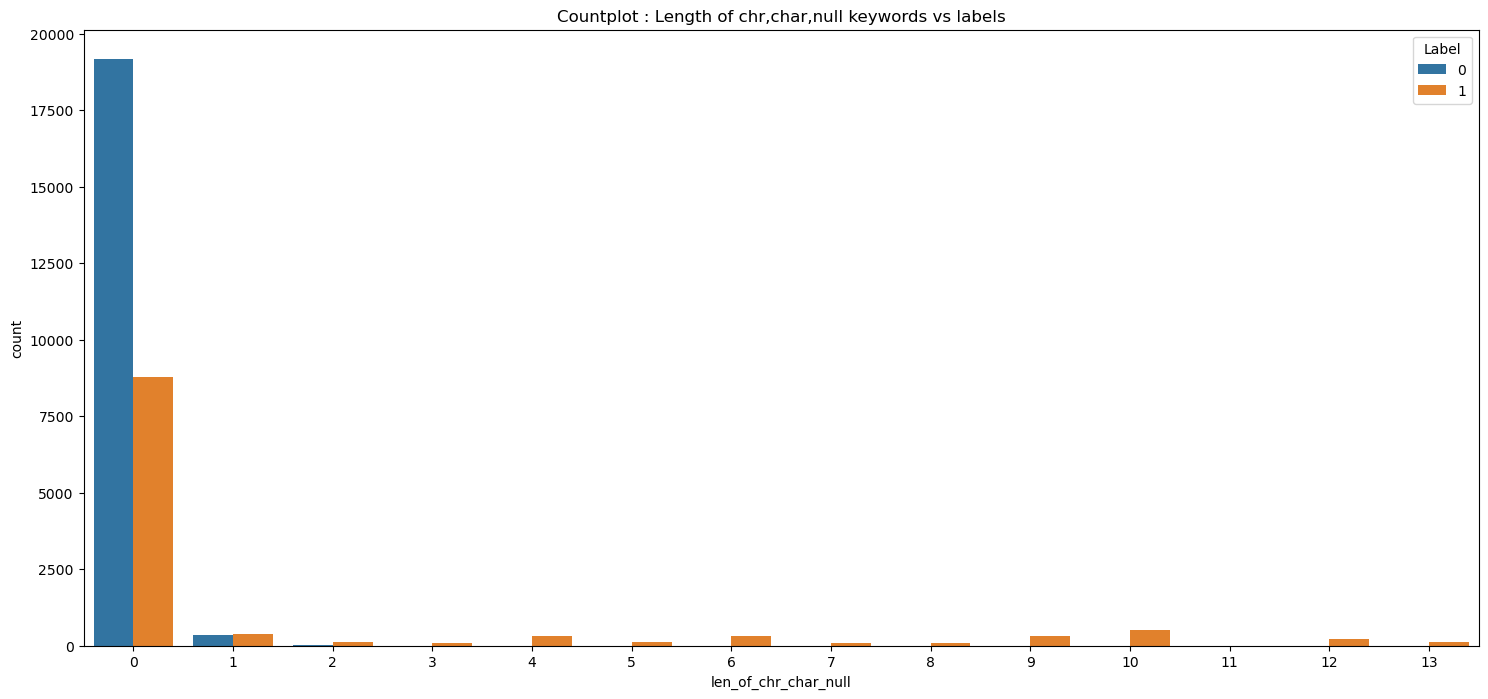

In [330]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['len_of_chr_char_null'],hue = data['Label'],data=data)

plt.title("Countplot : Length of chr,char,null keywords vs labels")
plt.show()

####### Observations :

###### Lot of label 0 and label 1 queries does not contain the above queries majority being the normal sql queries.
###### As length of these keywords increases i.e after the length 2 the chances of a query becoming a sql injection query also increases.
###### we can write simple rule based model like this : if(len_of_chr_char_null >=2 ) then label 1 else: label 0

#### number of genuine keywords in each query

In [334]:
data['genuine_keywords'].describe()

count    30902.000000
mean         1.015695
std          1.151811
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: genuine_keywords, dtype: float64

###### Observations :

###### These keywords lie in the range of 0 to 8.
###### 25 percent of queries does not contain these keywords

#### Countplot : count of genuine keywords vs labels

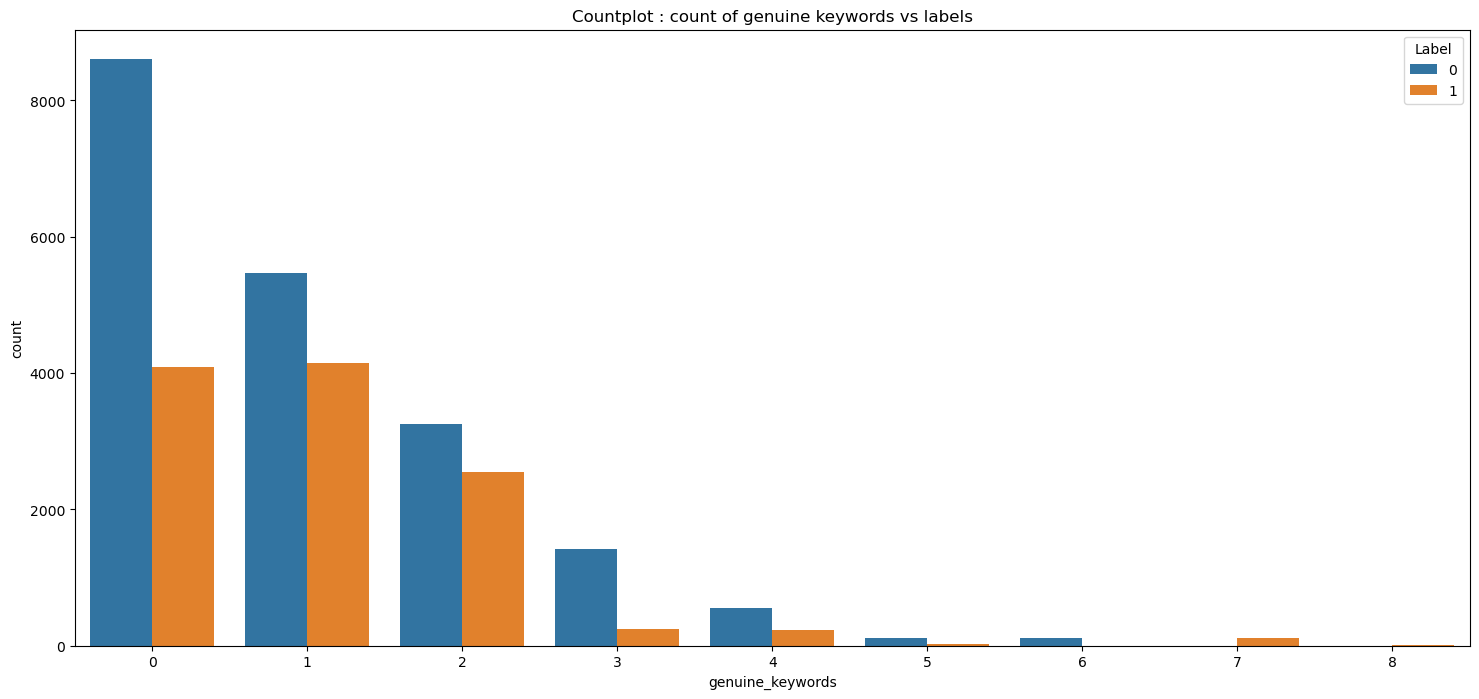

In [338]:
plt.figure(figsize = (18,8))

sns.countplot(x = data['genuine_keywords'],hue = data['Label'],data=data)

plt.title("Countplot : count of genuine keywords vs labels")
plt.show()

###### Observations :

###### There is slightly overlap between classes.
###### As we can observe if the number of genuine keywords is 6 then it is normal sql query i.e label 0 and if the number of genuine keywords are 7 then it is malicious sql query. if(genuine_keywords == 6): label 0 elif(genuine_keywords == 7): label 1

#### Bivariate Analysis of extracted features

###### From the above univariate analysis below are the features that are helpful in predicting the given query is sqli query or not - no_single_qts - no_double_qts - no_punct - no_single_cmnt - no_mult_cmnt - no_space - no_perc - no_log_opt - no_arith - no_null - no_hexa - no_alpha - no_digit

#### Pairplots of no_single_qts, no_double_qts, no_punct, no_single_cmnt features

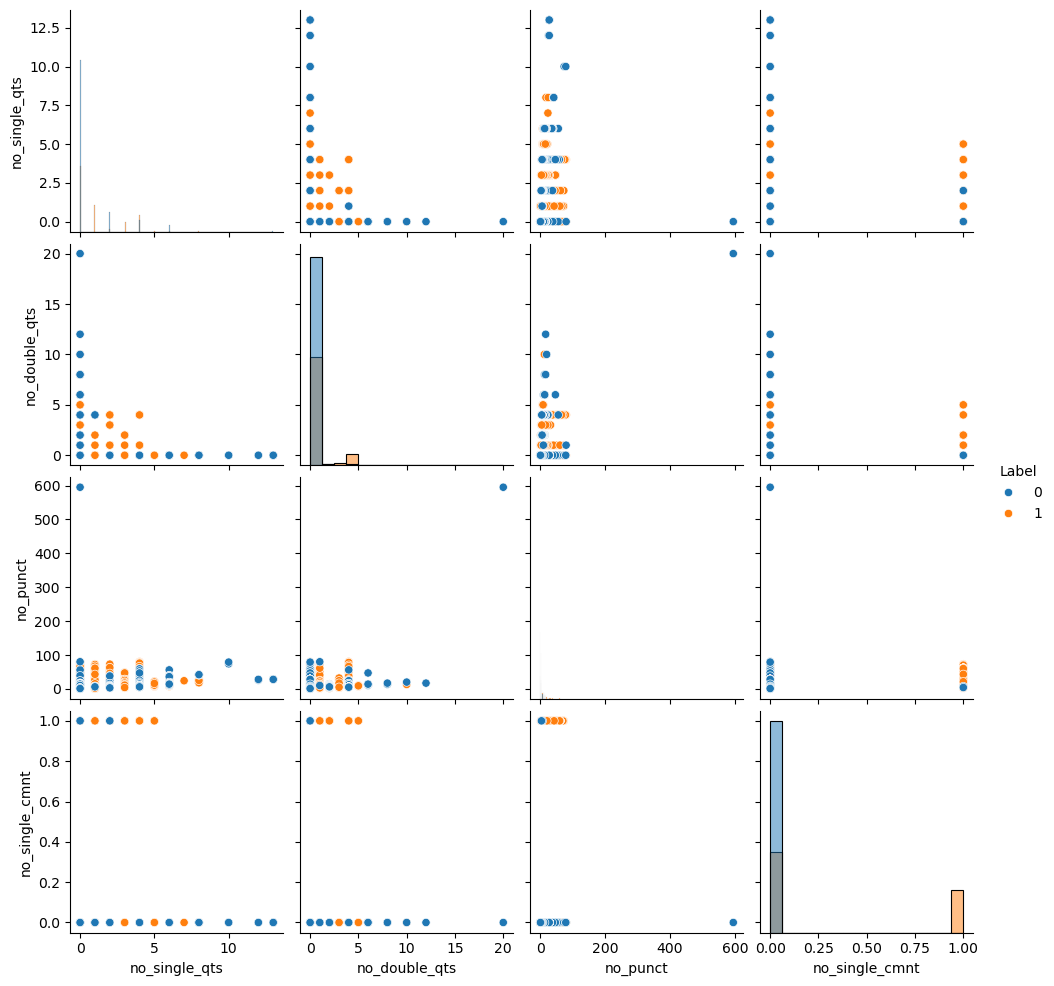

In [344]:
#pair plot of the above features 
#plotting all the features once will take lot of space and graphs does not look better for analysis
#so will take sample of features and plot
sns.pairplot(data = data,hue = 'Label',vars = ['no_single_qts',
       'no_double_qts', 'no_punct', 'no_single_cmnt'],diag_kind = "hist")
plt.show()

###### Observations :

###### no_single_qts vs no_single_cmnt, no_punct vs no_single_cmnt are easily differntiable and helpful in differntiating between sqli query and sql query.
###### we can write a simple rule based model like : if(no_single_cmnt > 10 and no_punct > 200): then label 0 else: label 1

#### Pairplots of no_mult_cmnt, no_space, no_perc, no_log_opt features

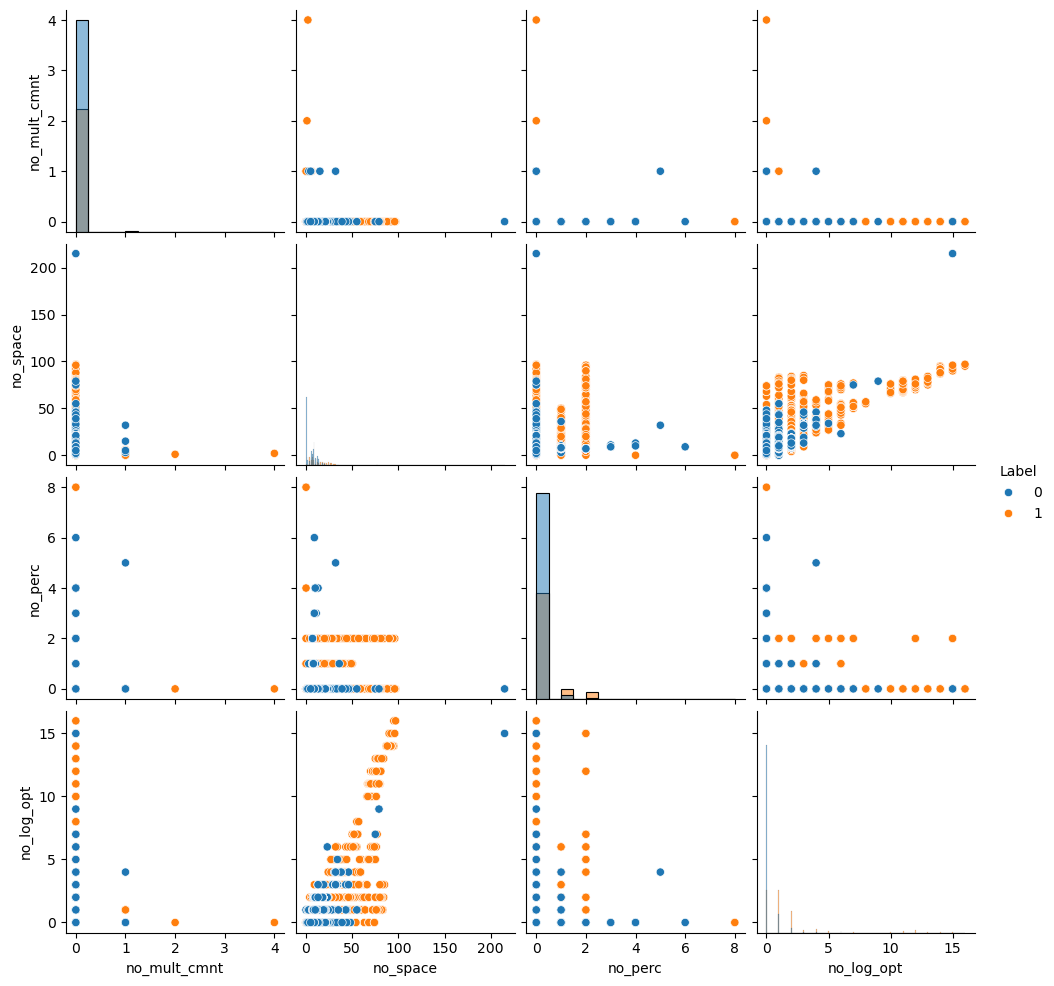

In [349]:
#will take other features to plot
sns.pairplot(data = data,hue = 'Label',vars = ['no_mult_cmnt',
       'no_space', 'no_perc', 'no_log_opt'
     ],diag_kind = "hist")
plt.show()

###### Observations :

###### Almost all the points are jumbled there are no features helpful in differntiating the labels

#### Pairplots of no_arith, no_null, no_hexa, no_alpha, no_digit features

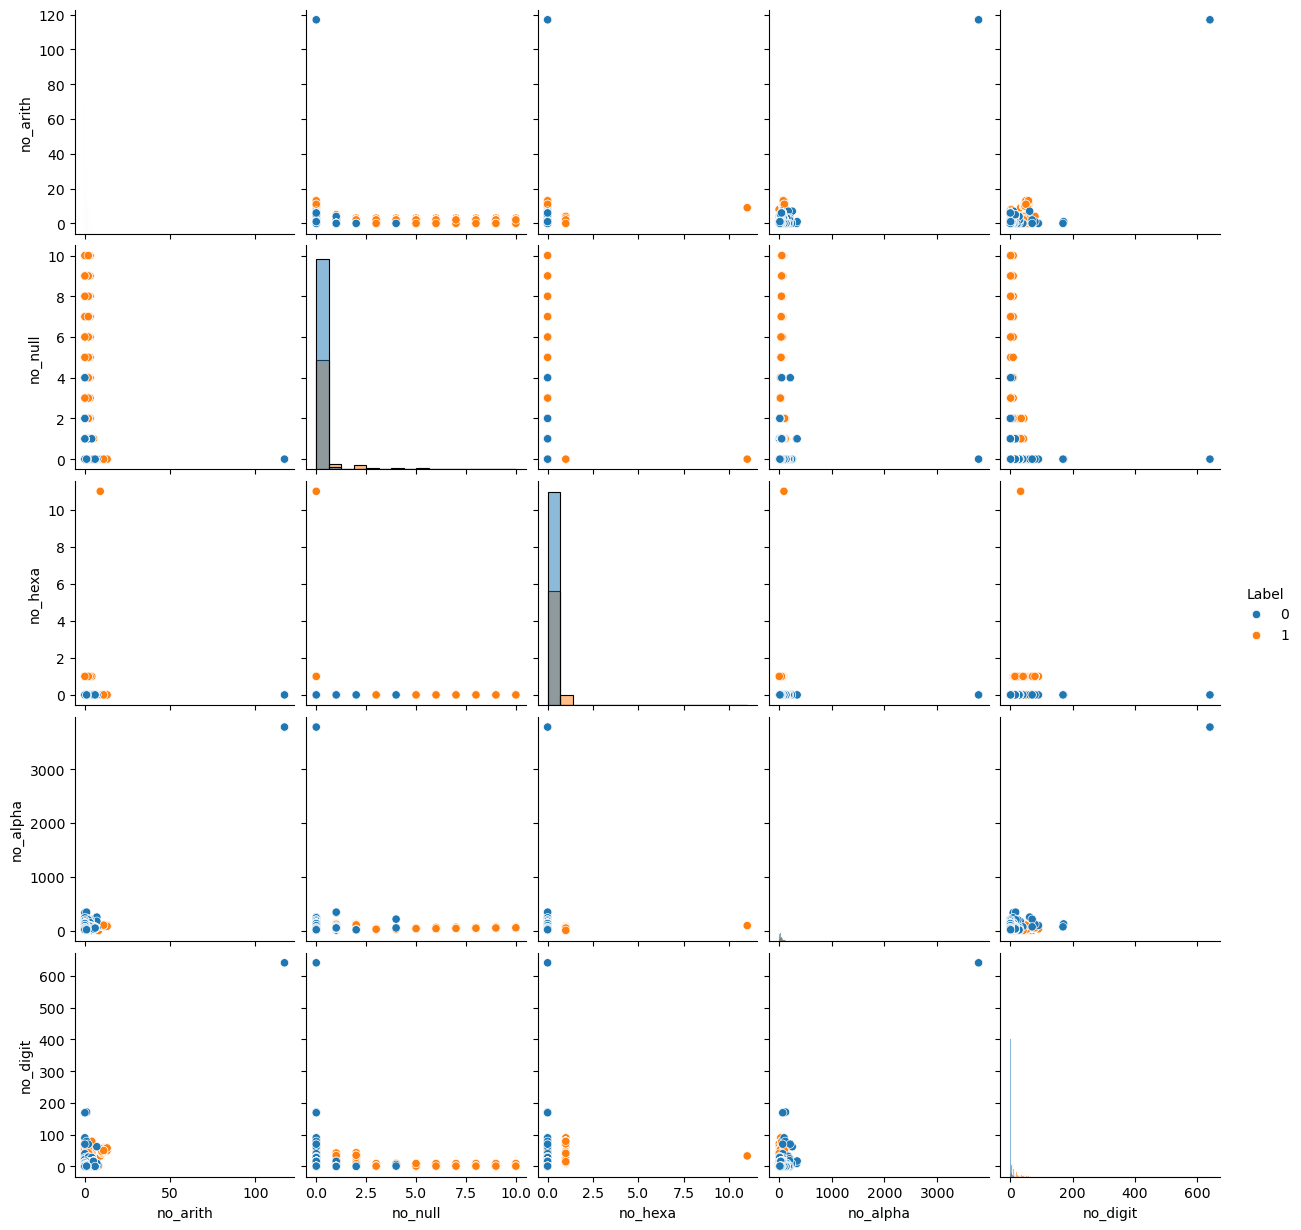

In [353]:
sns.pairplot(data = data,hue = 'Label',vars = ['no_arith', 'no_null', 'no_hexa',
       'no_alpha', 'no_digit'],diag_kind = "hist")
plt.show()


###### Observations :

###### no null vs no_digit and no_arith vs no_digit are the graphs helpful in predicting labels.

###### Simple rule model.

               if(no_digit > 200)
                    then label 0
               else:
                   label 1

#### Check Extracted features are helpful for classification or not.

In [357]:
#use T-SNE for dimension reduction to extracted features to 2-dimension

tsne_data = TSNE(n_components = 2,n_jobs = -1).fit_transform(data[['query_len', 'num_words_query', 'no_single_qts',
       'no_double_qts', 'no_punct', 'no_single_cmnt', 'no_mult_cmnt',
       'no_space', 'no_perc', 'no_log_opt', 'no_arith', 'no_null', 'no_hexa',
       'no_alpha', 'no_digit','len_of_chr_char_null','genuine_keywords']])

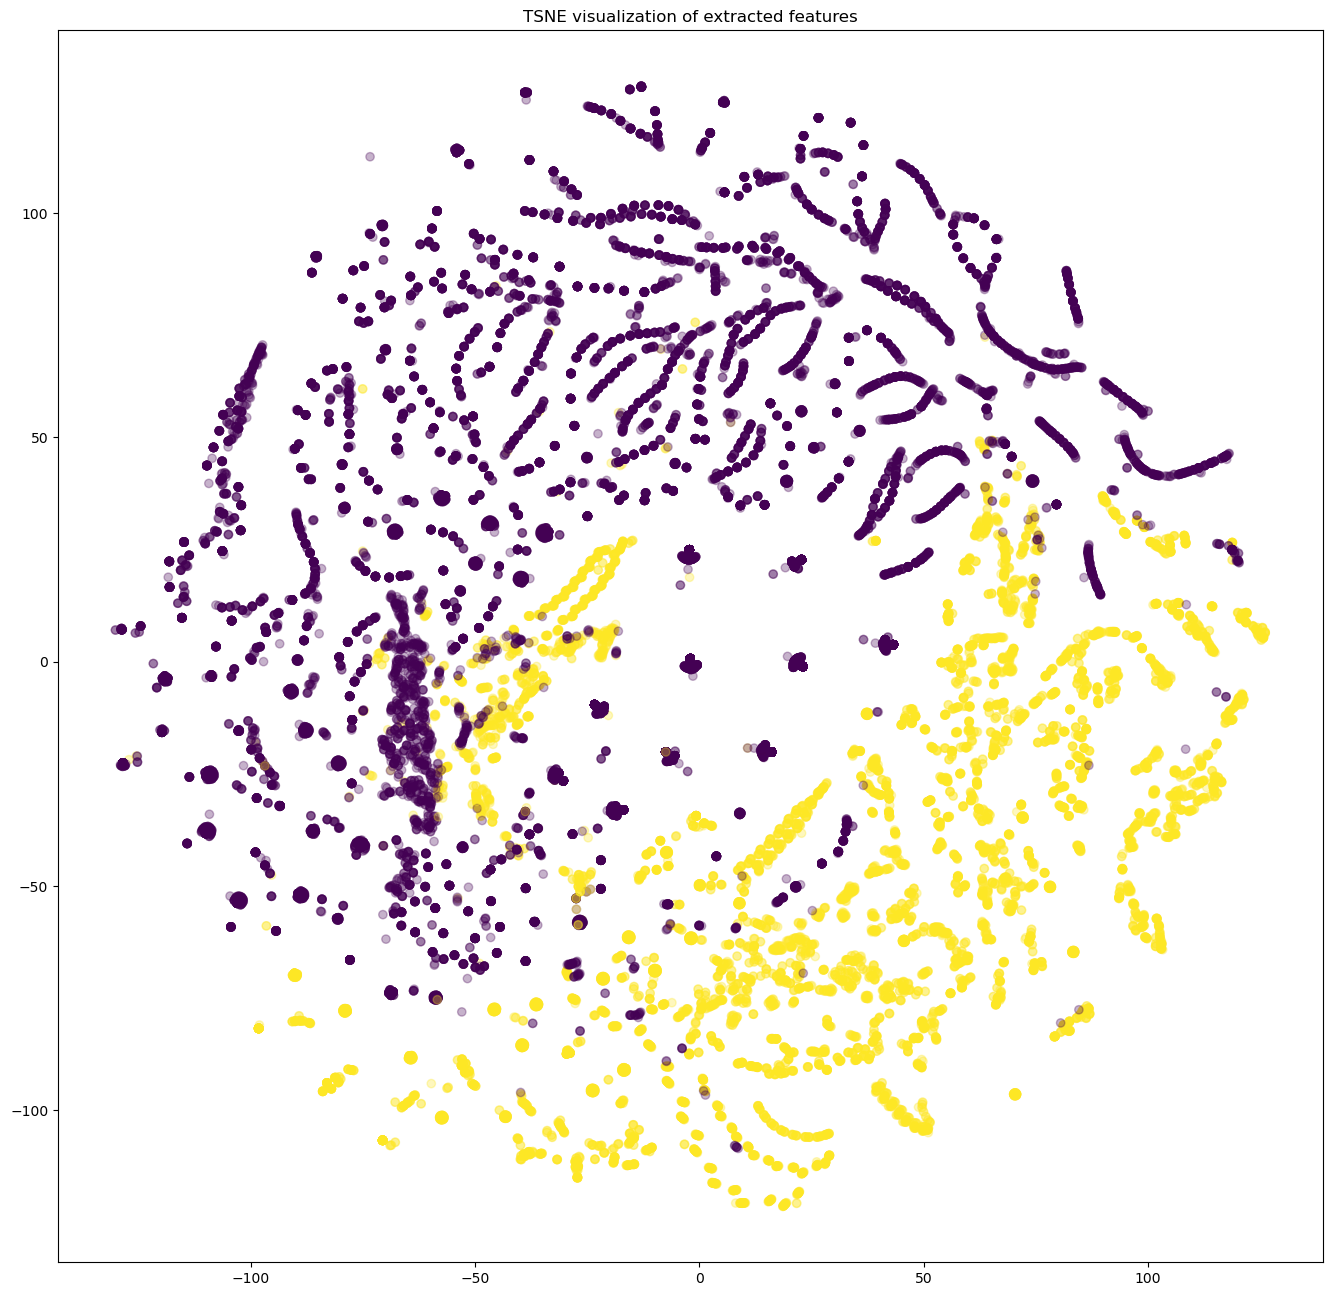

In [358]:
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(tsne_data[:,0], 
            tsne_data[:,1], 
            c=data['Label'], alpha=0.3)
plt.title('TSNE visualization of extracted features')
plt.show()


###### Observations :

###### Some points are overlapping but almost points are well separated
###### Features are helpfull in model building..

### Conclusions :

##### -> The dataset contain duplicate rows and same queries have different labels that are removed.
##### -> Dataset also contains empty queries that are found while doing the analysis of extrcated feature i.e number of words in query.
##### -> There is a class imbalance i.e majority of data points belongs to label 0 that are normal sql queries or plain text. 63 percent of them are label 0 and 37 percent of them are label 1.
##### -> as a part of text preprocessing converted text to lowercase because all the characters or text are important in predicting labels.
##### -> Wordclouds are plotted to observe the most occuring words in sql and sqli queries. this will be later used for feature extraction.
##### -> Found out null,char,chr etc are the words which occur most in sqli query. so we can featurize number_of null values in a query etc.
##### -> Normal sql keywords are found in sql queries.
##### -> Analysis of the Extracted features are done.
##### -> All features are helpful in predicting the labels. except query_length and number of words in a query these both features were overlapping we have seen through the distribution plots.
##### -> Apart from these two features all are helpful in predicting the labels with some threshold set we have seen it using rule based model.
##### -> Used countplots,boxplots,violin plots and distribution plots to analyze the features.
##### -> Some distributions look like lognormal distributed or power law distributed so applied logarithmic and box-cox transformations to check whether they can be transformed to Guassian distributed or not this can be very helpful while model building.
##### -> To check Guassian distributed or not used Q-Q plots
##### -> Bivariate Analysis is done on all features found out some features are helpful written some rule based models based on some conditions of features.
##### -> finally TSne is used to analyze the features that were extracted are helpful or not as a result some points are overlapping but almost all points are separated well.
##### -> Based on the EDA done above. The primary performance metrics that will be used is : - From the above TSNE visualizations we can see that some data points are misclassified. - So we want to know how much of the data points are misclassified. - so we can use confusion matrix as a performance metrics. - More about the confusion matrix : https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62